In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping
import random
#import keras_tuner as kt


### Cargue de los datos

In [2]:
# Cargar archivos (rutas relativas desde notebooks/)
train = pd.read_csv("../data/raw/train_data.csv")
test = pd.read_csv("../data/raw/test_data.csv")
sample_submission = pd.read_csv("../data/raw/sampleSubmission.csv")

### Normalización de los datos

In [3]:
# Separar features y target
X = train.drop(columns=["ID", "Bankruptcy"])
y = train["Bankruptcy"]

# Guardar ID del test para el submission
test_ids = test["ID"]
X_test = test.drop(columns=["ID"])

# Dividir training en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#X_train_scaled[:3]  # Mostrar ejemplo de datos escalados

In [11]:
X_train

,Realized.Sales.Gross.Profit.Growth.Rate,Operating.Expense.Rate,Operating.Profit.Per.Share..Yuan...,Gross.Profit.to.Sales,Tax.rate..A.,Current.Liability.to.Liability,Continuous.Net.Profit.Growth.Rate,Long.term.Liability.to.Current.Assets,Total.assets.to.GNP.price,Current.Liabilities.Equity,...,Per.Share.Net.profit.before.tax..Yuan...,Continuous.interest.rate..after.tax.,Liability.Assets.Flag,Working.Capital.to.Total.Assets,Degree.of.Financial.Leverage..DFL.,Operating.Gross.Margin,Contingent.liabilities.Net.worth,Operating.Profit.Growth.Rate,Cash.Flow.to.Liability,Quick.Assets.Total.Assets
372,0.017595,1.625654e+09,0.199018,0.610659,0.684576,0.813006,0.418868,0.000000,0.012756,0.334422,...,0.408457,0.781072,0,0.721571,0.066951,0.710968,0.024980,0.822405,0.573682,0.268848
789,0.014537,5.186739e-05,0.161424,0.659025,0.221063,0.950153,0.366822,0.000000,0.000901,0.350626,...,0.204542,0.766572,0,0.793894,0.044066,0.590928,0.051679,0.890405,0.617939,0.435668
2010,0.033672,7.292890e+11,0.200205,0.565843,0.000000,0.901144,0.263436,0.000000,0.001134,0.534537,...,0.238582,0.878608,0,0.789804,0.014695,0.617468,0.039728,0.872666,0.468507,0.677971
942,0.026595,1.598731e-04,0.139212,0.758248,0.350913,0.866208,0.220460,0.010759,0.048601,0.326641,...,0.138091,0.831515,0,0.842357,0.013604,0.707542,0.042931,0.839007,0.466816,0.293606
2004,0.122168,2.364116e+07,0.094892,0.670565,0.000000,0.670799,0.275292,0.000626,0.015452,0.483363,...,0.113783,0.838376,0,0.706790,0.029108,0.695559,0.008039,0.844258,0.503456,0.283483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,0.071644,3.375989e-04,0.085268,0.640580,0.000000,0.971691,0.317109,0.001709,0.006302,0.569113,...,0.214128,0.749701,0,0.817000,0.077506,0.549108,0.024010,0.904497,0.425739,0.254163
413,0.020769,2.136112e-04,0.280379,0.629631,0.244724,0.977060,0.286949,0.000000,0.000077,0.351380,...,0.255776,0.787220,0,0.918954,0.013204,0.716689,0.003050,0.884787,0.420844,0.649382
1196,0.014409,2.566897e+11,0.164064,0.652975,0.000000,0.938177,0.366675,0.004059,0.012207,0.352870,...,0.201438,0.766283,0,0.748458,0.044280,0.584092,0.049687,0.890217,0.609445,0.388051
1424,0.022020,1.104138e+08,0.062115,0.674847,0.000000,0.790101,0.163518,0.065185,0.038360,0.310369,...,0.296579,0.790850,0,0.732996,0.128488,0.749322,0.019528,0.849328,0.553383,0.413459


### Redes Neuronales

In [20]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf

### Seleccionar el número de capas

In [24]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

# Fijar semilla para reproducibilidad
np.random.seed(42)  # Para la aleatorización de datos
tf.random.set_seed(42)  # Para la inicialización de pesos

# Función para construir el modelo
def build_model(architecture, input_dim):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))  # Capa de entrada con 63 características (input_dim)

    # Añadir capas ocultas según la arquitectura especificada
    for units, dropout_rate in architecture:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))

    # Capa de salida con 1 neurona para clasificación binaria
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compilación con tasa de aprendizaje explícita
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=[AUC(name='auc')])
    
    return model

# Definir las arquitecturas a probar
architectures = [
    [(64, 0.3)],  # Arquitectura de 1 capa oculta
    [(128, 0.3), (64, 0.3)],  # Arquitectura de 2 capas ocultas
    [(128, 0.3), (64, 0.3), (32, 0.2)],  # Arquitectura de 3 capas ocultas
    [(128, 0.3), (64, 0.3), (32, 0.2), (16, 0.2)],  # Arquitectura de 4 capas ocultas
    [(128, 0.3), (64, 0.3), (32, 0.2), (16, 0.2), (8, 0.1)],  # Arquitectura de 5 capas ocultas
    [(128, 0.3), (64, 0.3), (32, 0.2), (16, 0.2), (8, 0.1), (8, 0.1)],  # Arquitectura de 6 capas ocultas
    [(128, 0.3), (64, 0.3), (32, 0.2), (16, 0.2), (8, 0.1), (8, 0.1), (8, 0.1), (8, 0.1), (8, 0.1), (8, 0.1)]  # Arquitectura de 10 capas
]

# Lista para almacenar los resultados
results = []

# Usar KFold para la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Entrenar el modelo con cada arquitectura
for idx, arch in enumerate(architectures):
    print(f"\nProbando arquitectura {idx+1}: {arch}")
    auc_scores = []
    
    for train_index, val_index in kf.split(X_train_scaled):
        # Crear los conjuntos de entrenamiento y validación para este fold
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]  # Usar .iloc[] para Series
        
        # Crear el modelo
        model = build_model(arch, X_train_scaled.shape[1])

        early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)

        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=500,
                            callbacks=[early_stop],
                            verbose=0)

        val_pred = model.predict(X_val_fold).ravel()
        auc = roc_auc_score(y_val_fold, val_pred)
        auc_scores.append(auc)
        print(f"AUC validación: {auc:.4f}")
    
    # Promediar los resultados de los folds
    mean_auc = np.mean(auc_scores)
    results.append((arch, mean_auc))

# Ordenar y mostrar los resultados
results.sort(key=lambda x: x[1], reverse=True)
for arch, auc in results:
    print(f"Arquitectura: {arch}, AUC: {auc:.4f}")



Probando arquitectura 1: [(64, 0.3)]
11/11 [==============================] - 0s 800us/step
AUC validación: 0.9094
11/11 [==============================] - 0s 900us/step
AUC validación: 0.8133
11/11 [==============================] - 0s 800us/step
AUC validación: 0.8735
11/11 [==============================] - 0s 851us/step
AUC validación: 0.9261
11/11 [==============================] - 0s 900us/step
AUC validación: 0.8000

Probando arquitectura 2: [(128, 0.3), (64, 0.3)]
11/11 [==============================] - 0s 900us/step
AUC validación: 0.9227
11/11 [==============================] - 0s 900us/step
AUC validación: 0.8867
11/11 [==============================] - 0s 1ms/step
AUC validación: 0.7336
11/11 [==============================] - 0s 1ms/step
AUC validación: 0.8981
11/11 [==============================] - 0s 1ms/step
AUC validación: 0.8198

Probando arquitectura 3: [(128, 0.3), (64, 0.3), (32, 0.2)]
11/11 [==============================] - 0s 1ms/step
AUC validación: 0.9066
1


Probando optimizadores para arquitectura 1: [(64, 0.3)]
11/11 [==============================] - 0s 800us/step
Optimizador: SGD, AUC: 0.9201
Optimizador: Adam, AUC: 0.9606
Optimizador: RMSprop, AUC: 0.9597
Optimizador: Adagrad, AUC: 0.8454
Optimizador: Adadelta, AUC: 0.6400

Probando optimizadores para arquitectura 2: [(128, 0.3), (64, 0.3)]
11/11 [==============================] - 0s 900us/step
Optimizador: SGD, AUC: 0.9499
Optimizador: Adam, AUC: 0.9594
Optimizador: RMSprop, AUC: 0.9413
Optimizador: Adagrad, AUC: 0.8951
Optimizador: Adadelta, AUC: 0.4554

Probando optimizadores para arquitectura 3: [(128, 0.3), (64, 0.3), (32, 0.2)]
11/11 [==============================] - 0s 1ms/step
Optimizador: SGD, AUC: 0.9083
Optimizador: Adam, AUC: 0.9709
Optimizador: RMSprop, AUC: 0.9610
Optimizador: Adagrad, AUC: 0.7444
Optimizador: Adadelta, AUC: 0.6029

Probando optimizadores para arquitectura 4: [(128, 0.3), (64, 0.3), (32, 0.2), (16, 0.2)]
11/11 [==============================] - 0s 1ms/


Probando optimizadores para arquitectura 1: [(64, 0.3)]
11/11 [==============================] - 0s 800us/step


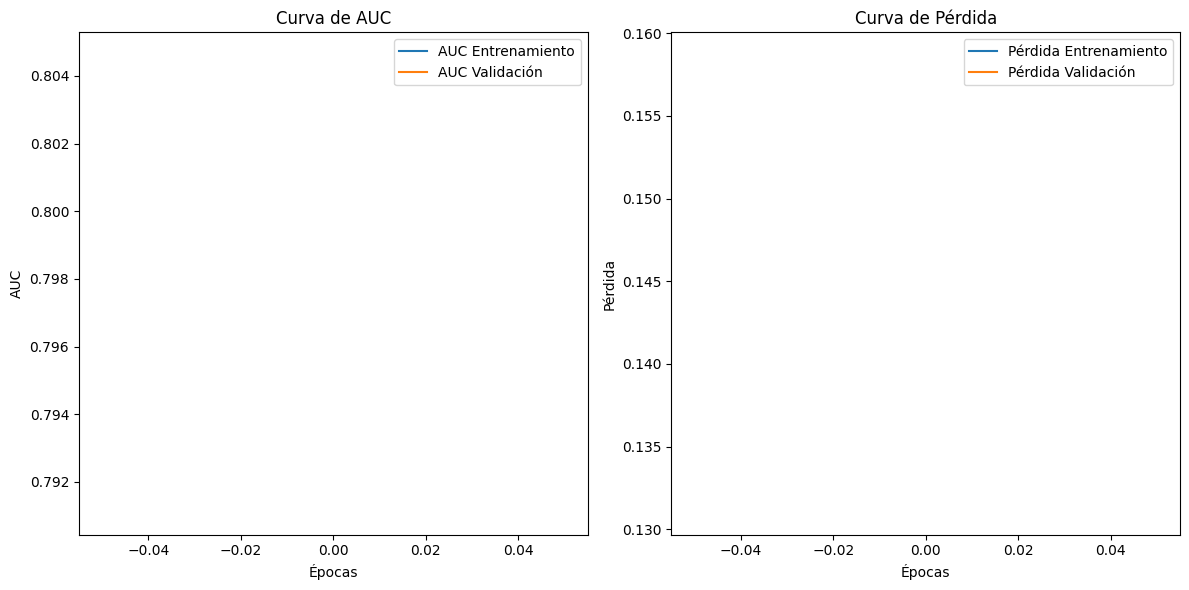

11/11 [==============================] - 0s 800us/step


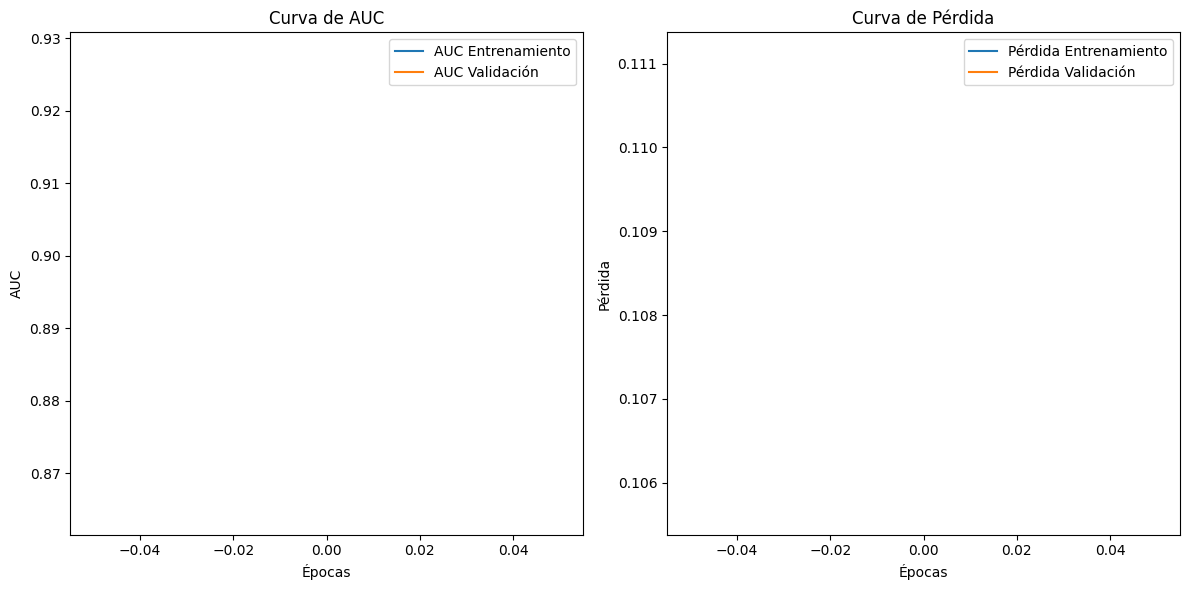

11/11 [==============================] - 0s 800us/step


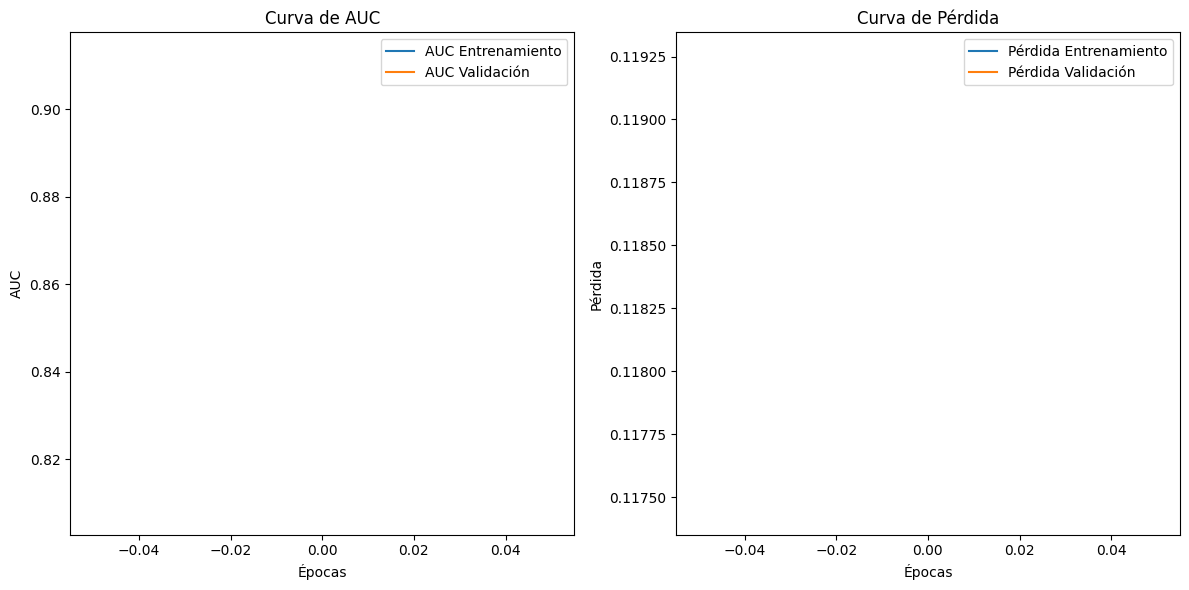

11/11 [==============================] - 0s 800us/step


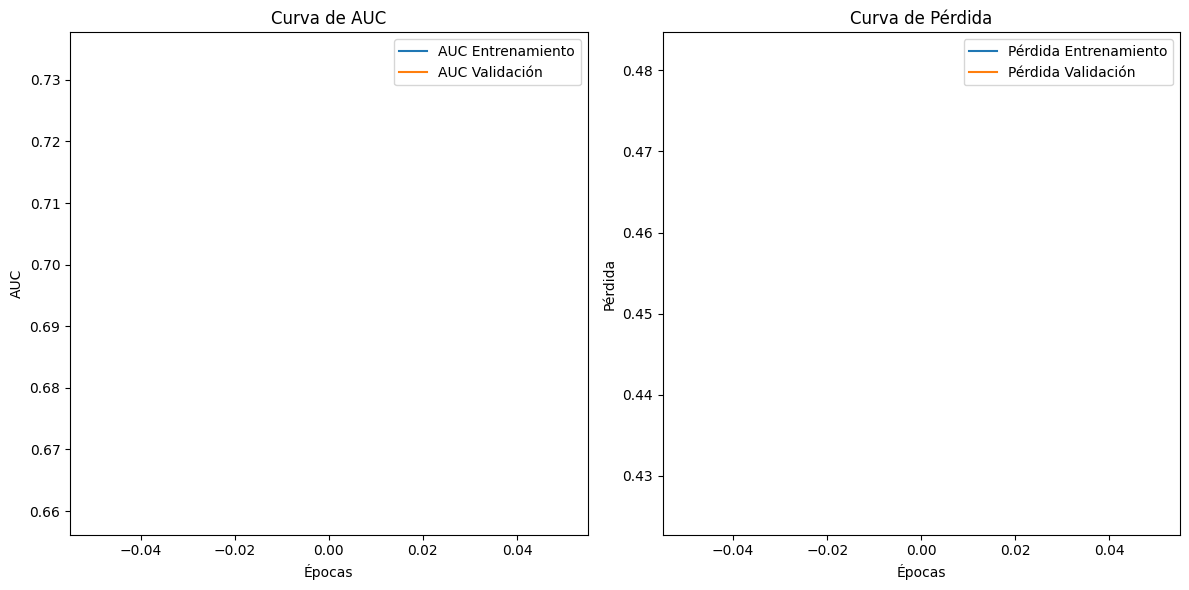

11/11 [==============================] - 0s 800us/step


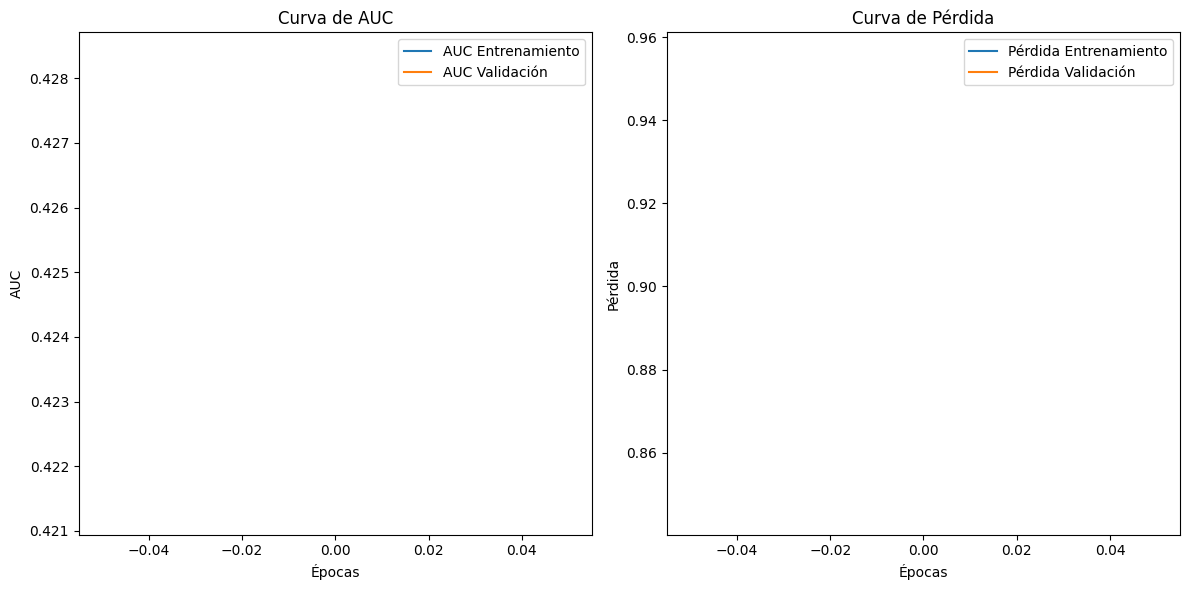

Optimizador: SGD
AUC Promedio: 0.9053
AUC Entrenamiento Promedio: 0.8441
AUC Validación Promedio: 0.8872
Pérdida Promedio: 0.1253
Pérdida Validación Promedio: 0.1053
Optimizador: Adam
AUC Promedio: 0.9768
AUC Entrenamiento Promedio: 0.9557
AUC Validación Promedio: 0.9449
Pérdida Promedio: 0.0752
Pérdida Validación Promedio: 0.0716
Optimizador: RMSprop
AUC Promedio: 0.9327
AUC Entrenamiento Promedio: 0.9305
AUC Validación Promedio: 0.9076
Pérdida Promedio: 0.0915
Pérdida Validación Promedio: 0.0848
Optimizador: Adagrad
AUC Promedio: 0.8279
AUC Entrenamiento Promedio: 0.6990
AUC Validación Promedio: 0.8105
Pérdida Promedio: 0.3994
Pérdida Validación Promedio: 0.3378
Optimizador: Adadelta
AUC Promedio: 0.4145
AUC Entrenamiento Promedio: 0.4275
AUC Validación Promedio: 0.4119
Pérdida Promedio: 0.9552
Pérdida Validación Promedio: 0.8580

Probando optimizadores para arquitectura 2: [(128, 0.3), (64, 0.3)]
11/11 [==============================] - 0s 1ms/step


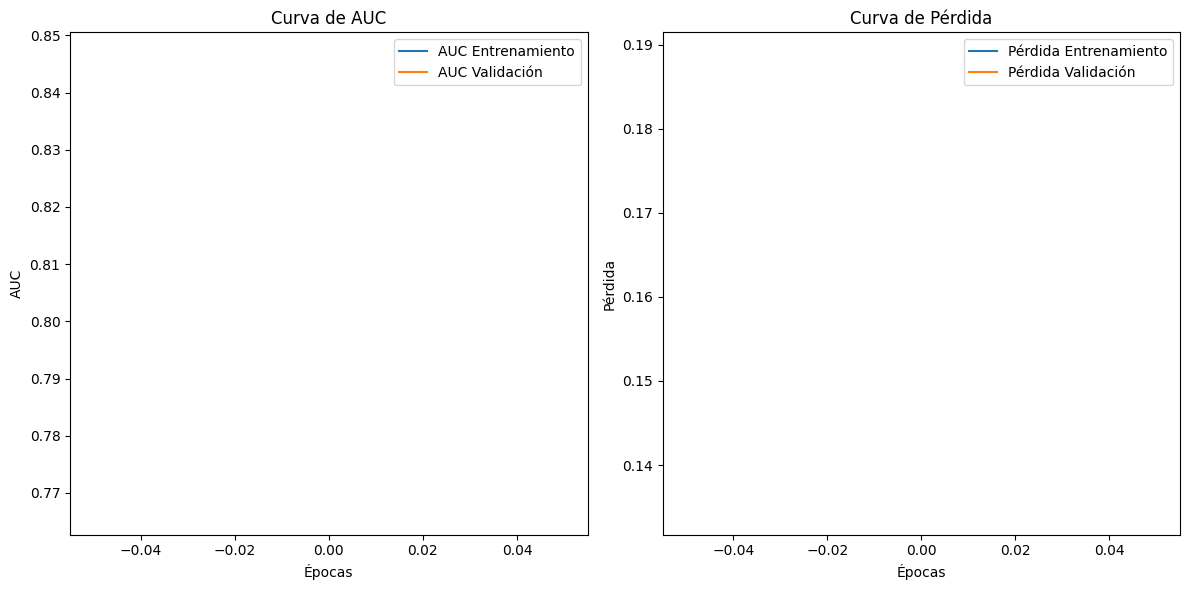

11/11 [==============================] - 0s 1ms/step


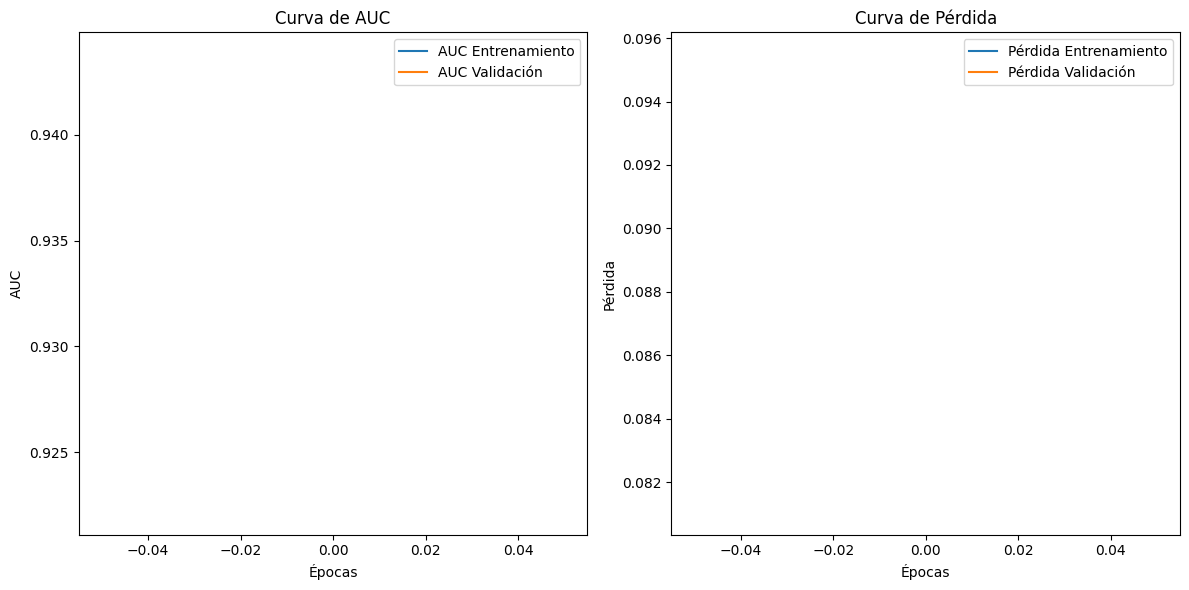

11/11 [==============================] - 0s 1ms/step


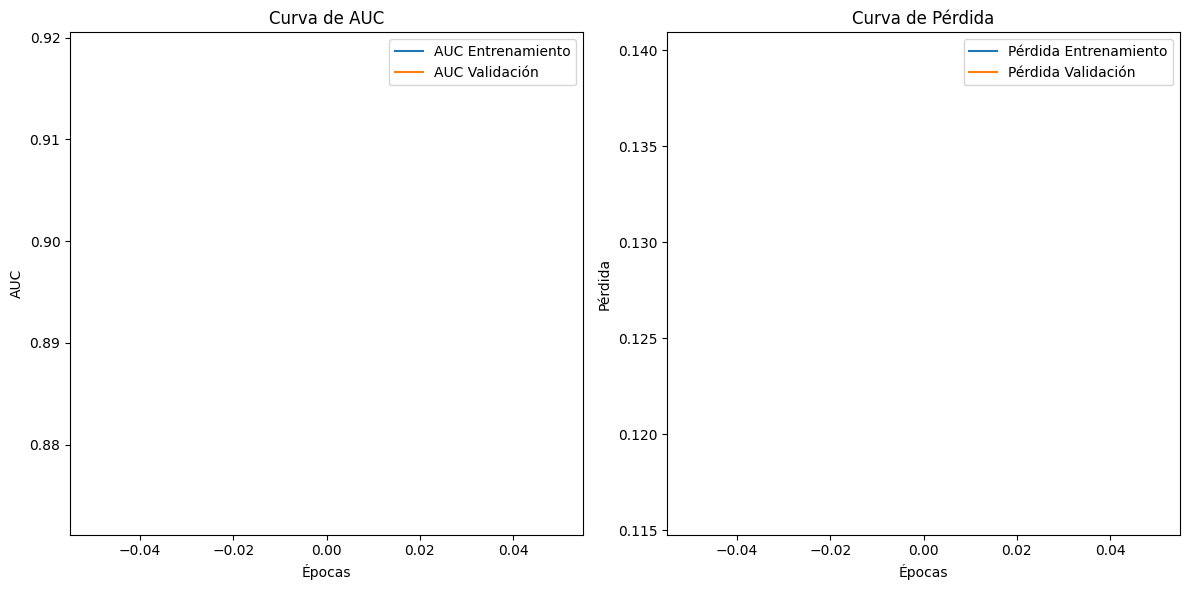

11/11 [==============================] - 0s 1ms/step


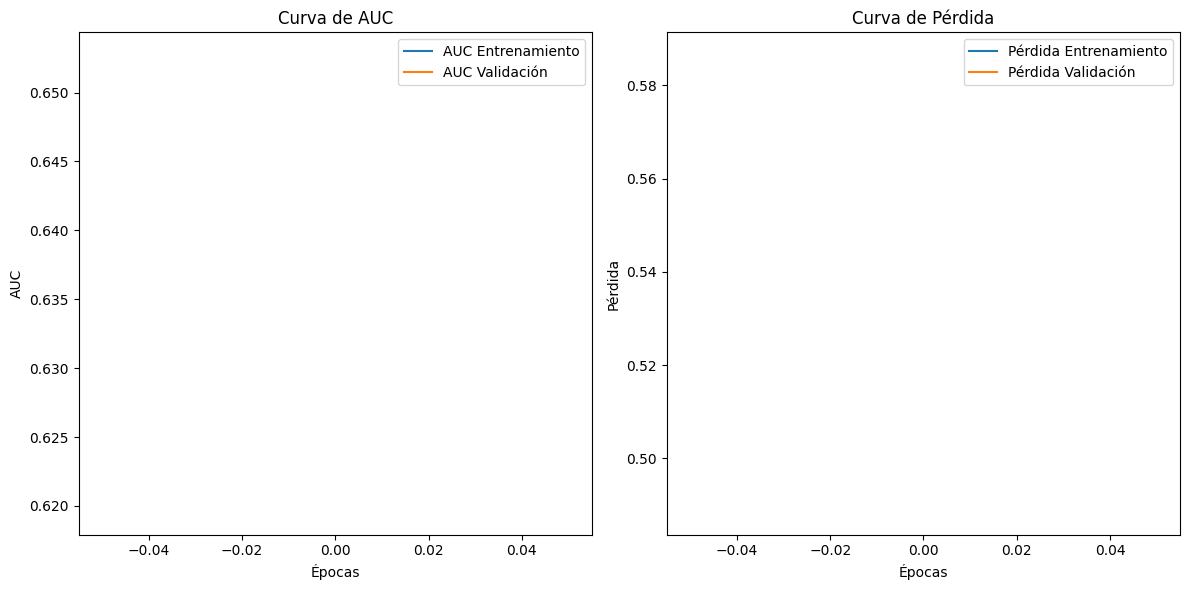

11/11 [==============================] - 0s 1ms/step


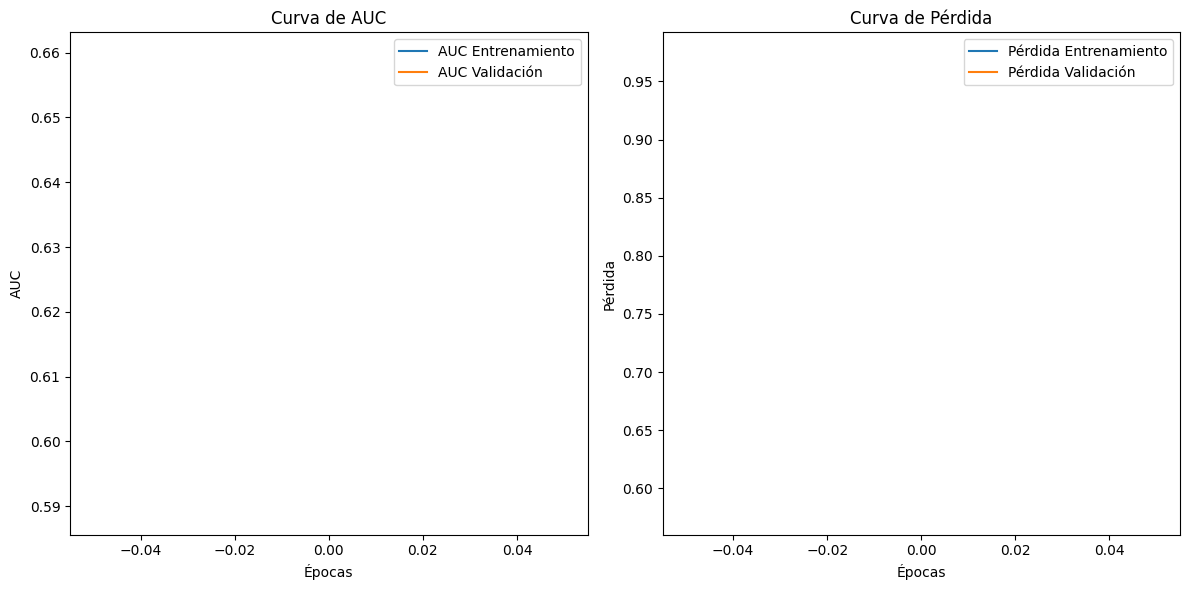

Optimizador: SGD
AUC Promedio: 0.9296
AUC Entrenamiento Promedio: 0.7863
AUC Validación Promedio: 0.9107
Pérdida Promedio: 0.1549
Pérdida Validación Promedio: 0.1127
Optimizador: Adam
AUC Promedio: 0.9686
AUC Entrenamiento Promedio: 0.9284
AUC Validación Promedio: 0.9493
Pérdida Promedio: 0.0898
Pérdida Validación Promedio: 0.0796
Optimizador: RMSprop
AUC Promedio: 0.9622
AUC Entrenamiento Promedio: 0.8914
AUC Validación Promedio: 0.9368
Pérdida Promedio: 0.1160
Pérdida Validación Promedio: 0.1007
Optimizador: Adagrad
AUC Promedio: 0.8082
AUC Entrenamiento Promedio: 0.6351
AUC Validación Promedio: 0.7922
Pérdida Promedio: 0.5326
Pérdida Validación Promedio: 0.4329
Optimizador: Adadelta
AUC Promedio: 0.6492
AUC Entrenamiento Promedio: 0.5915
AUC Validación Promedio: 0.6452
Pérdida Promedio: 0.9729
Pérdida Validación Promedio: 0.5818

Probando optimizadores para arquitectura 3: [(128, 0.3), (64, 0.3), (32, 0.2)]
11/11 [==============================] - 0s 1ms/step


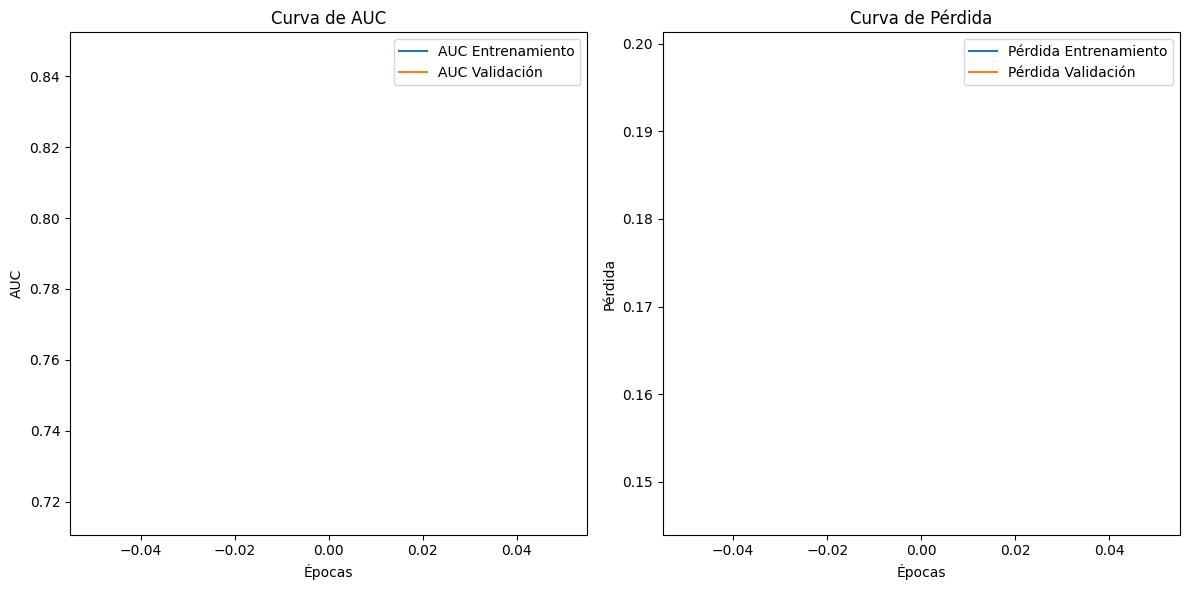

11/11 [==============================] - 0s 1ms/step


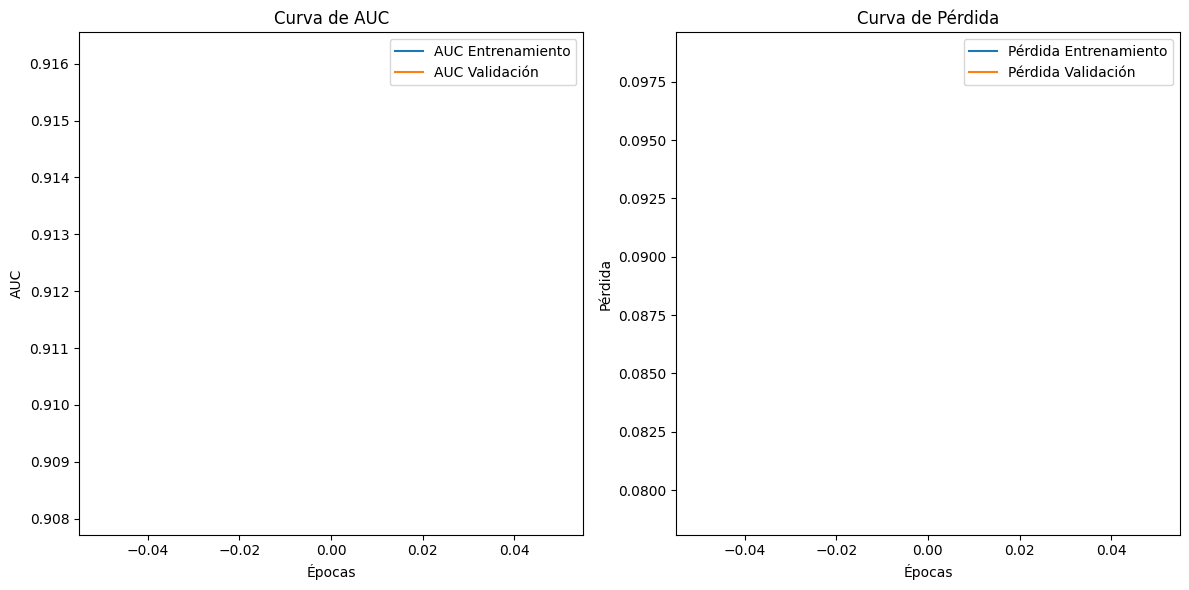

11/11 [==============================] - 0s 1ms/step


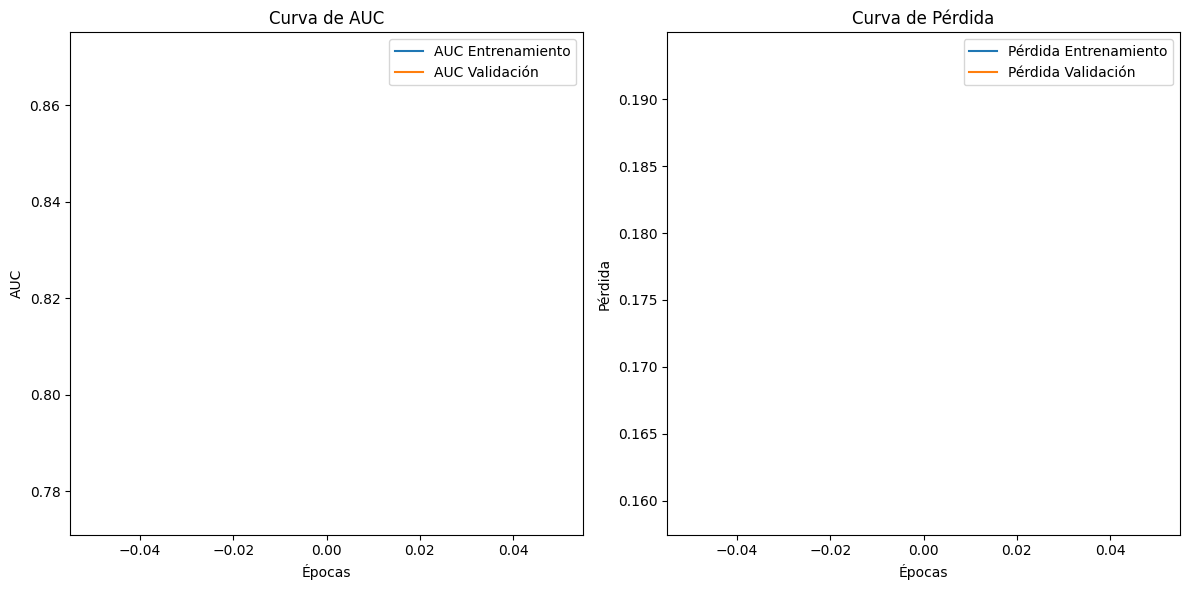

11/11 [==============================] - 0s 1ms/step


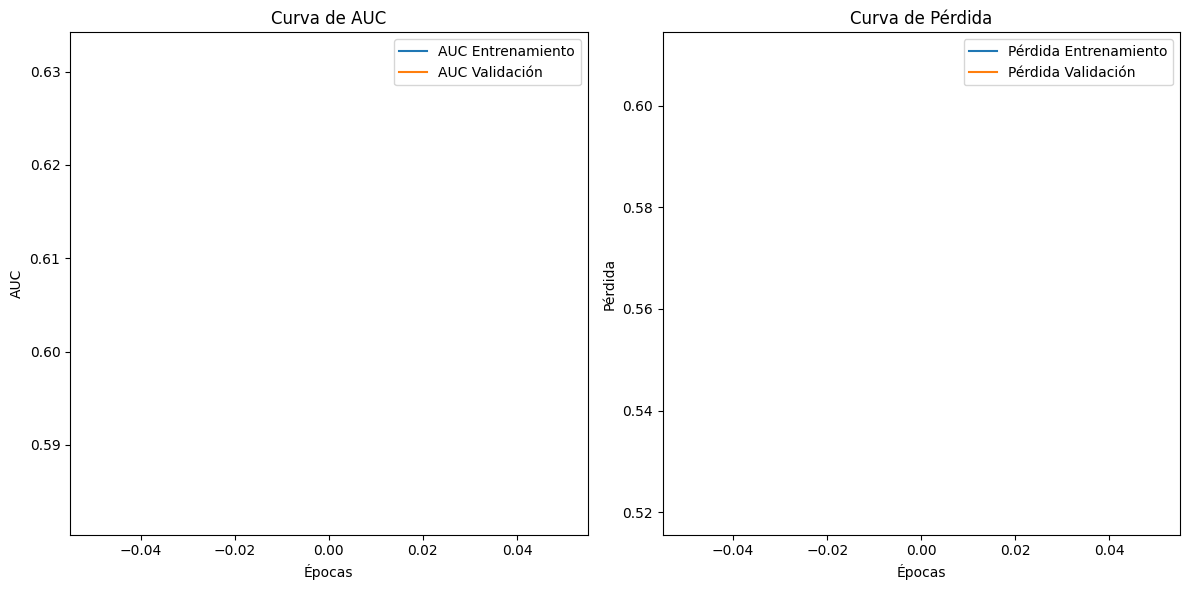

11/11 [==============================] - 0s 1ms/step


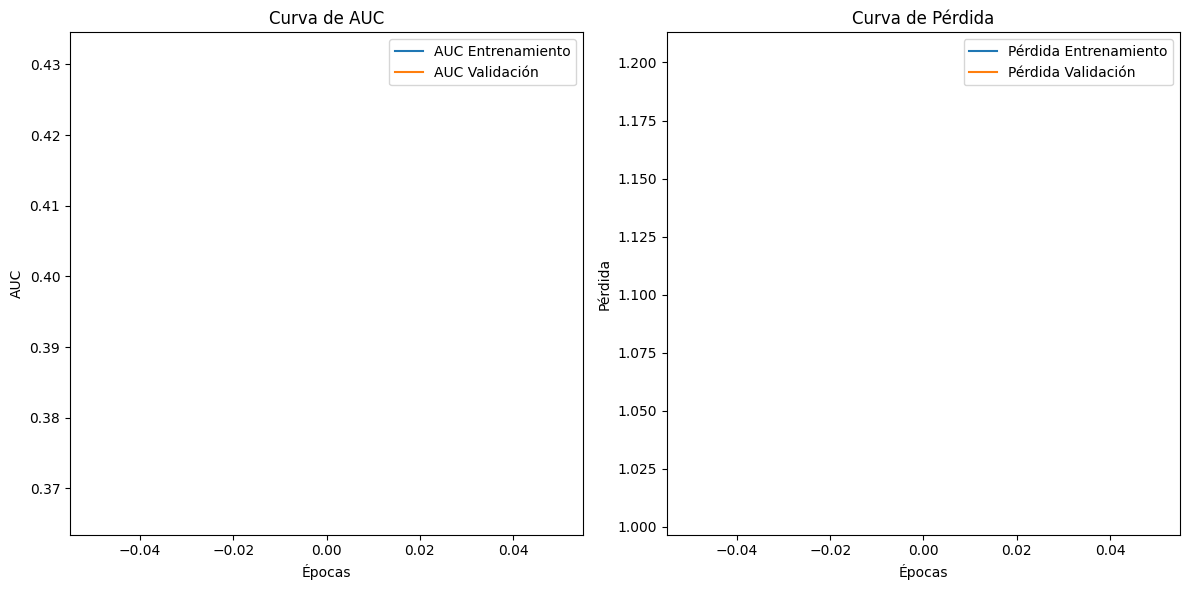

Optimizador: SGD
AUC Promedio: 0.8968
AUC Entrenamiento Promedio: 0.7273
AUC Validación Promedio: 0.8740
Pérdida Promedio: 0.1913
Pérdida Validación Promedio: 0.1415
Optimizador: Adam
AUC Promedio: 0.9560
AUC Entrenamiento Promedio: 0.9184
AUC Validación Promedio: 0.9367
Pérdida Promedio: 0.0912
Pérdida Validación Promedio: 0.0752
Optimizador: RMSprop
AUC Promedio: 0.8986
AUC Entrenamiento Promedio: 0.7761
AUC Validación Promedio: 0.8799
Pérdida Promedio: 0.1955
Pérdida Validación Promedio: 0.1551
Optimizador: Adagrad
AUC Promedio: 0.6699
AUC Entrenamiento Promedio: 0.5809
AUC Validación Promedio: 0.6544
Pérdida Promedio: 0.6051
Pérdida Validación Promedio: 0.5093
Optimizador: Adadelta
AUC Promedio: 0.3683
AUC Entrenamiento Promedio: 0.4305
AUC Validación Promedio: 0.3630
Pérdida Promedio: 1.0068
Pérdida Validación Promedio: 1.2085

Probando optimizadores para arquitectura 4: [(128, 0.3), (64, 0.3), (32, 0.2), (16, 0.2)]
11/11 [==============================] - 0s 1ms/step


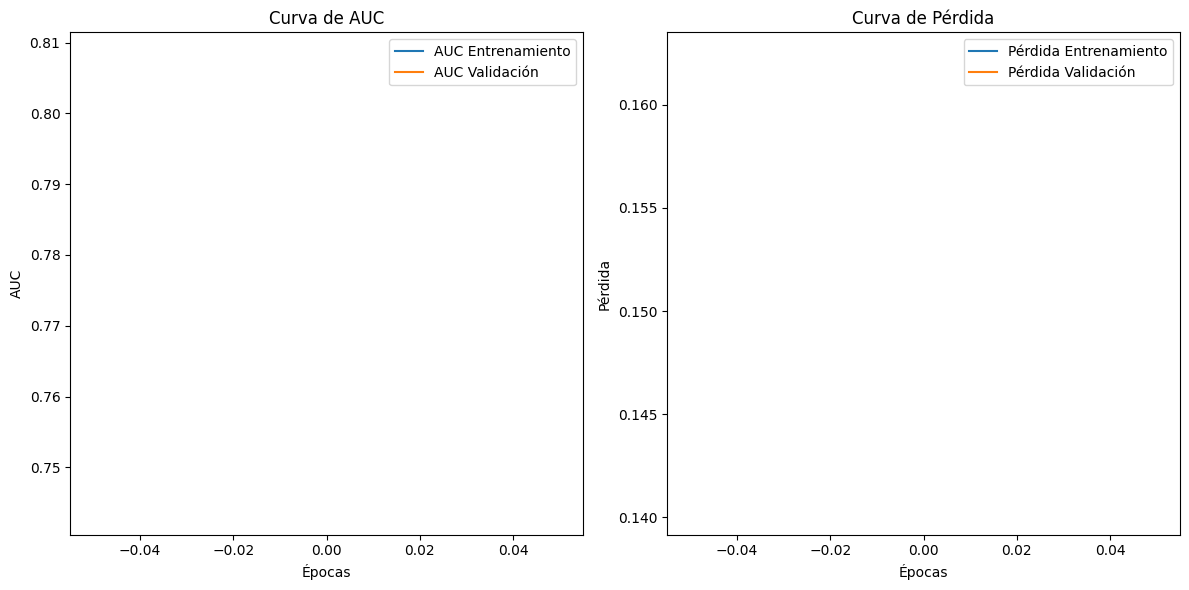

11/11 [==============================] - 0s 1ms/step


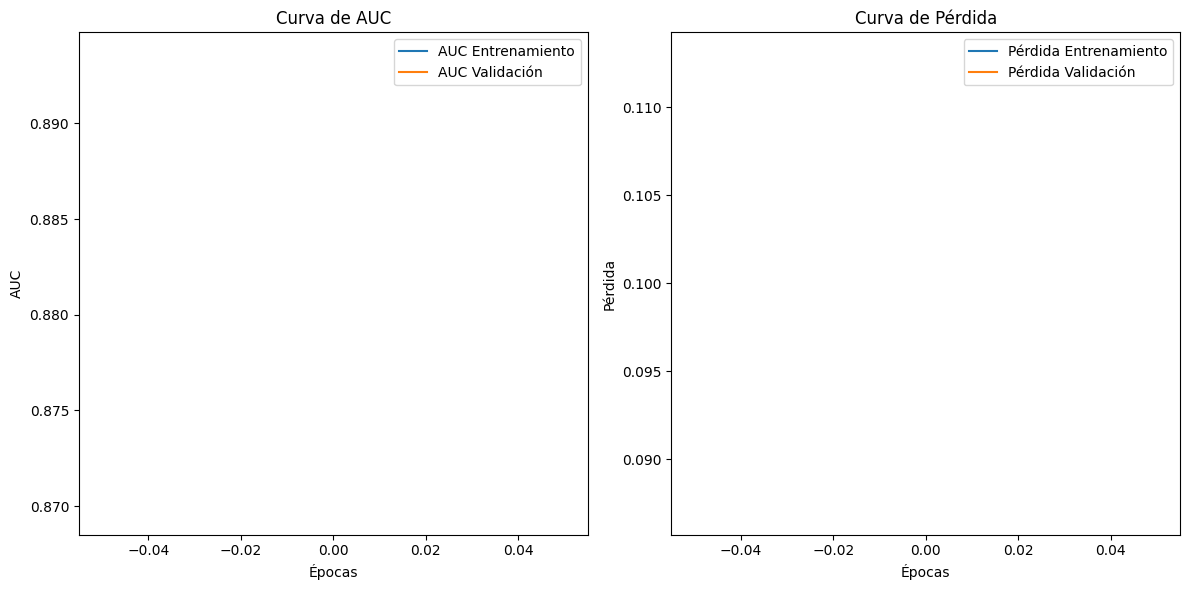

11/11 [==============================] - 0s 1ms/step


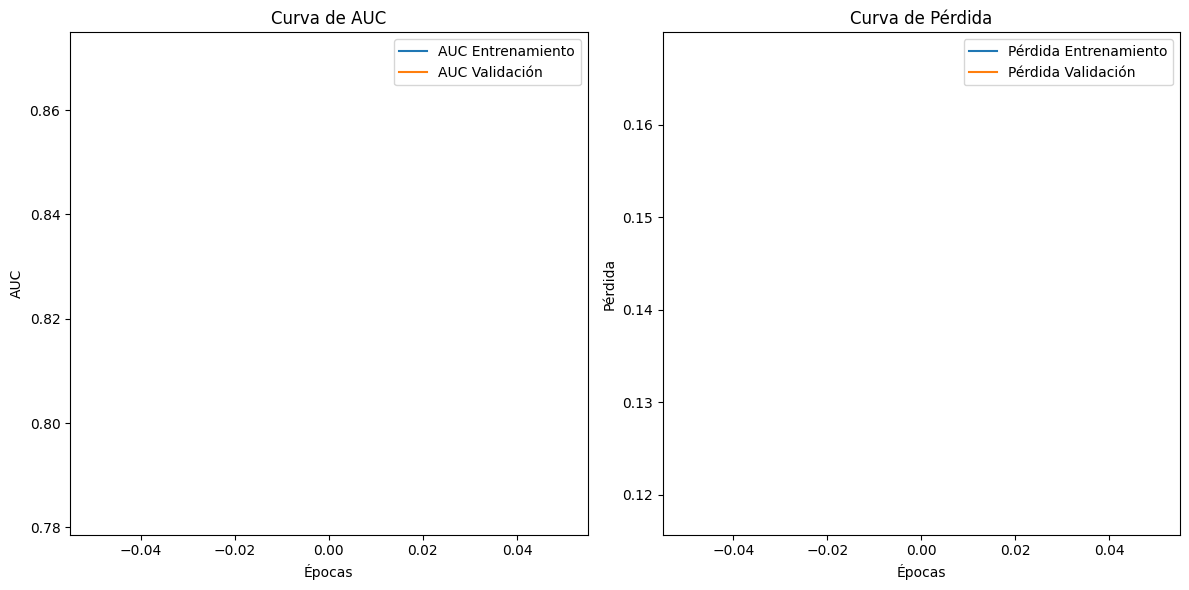

11/11 [==============================] - 0s 1ms/step


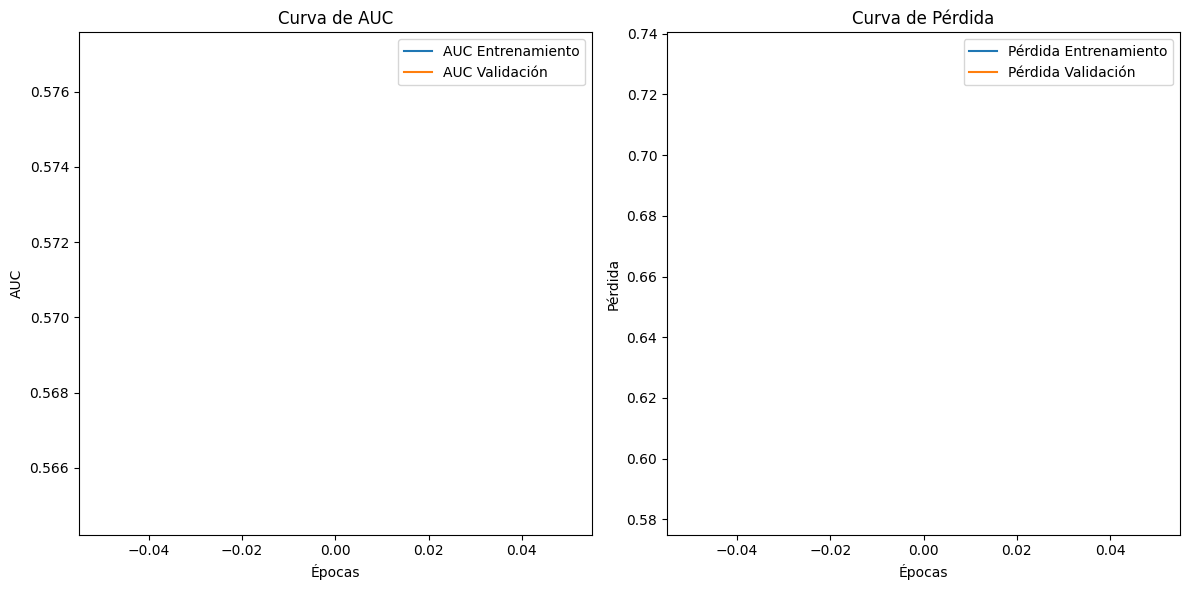

11/11 [==============================] - 0s 1ms/step


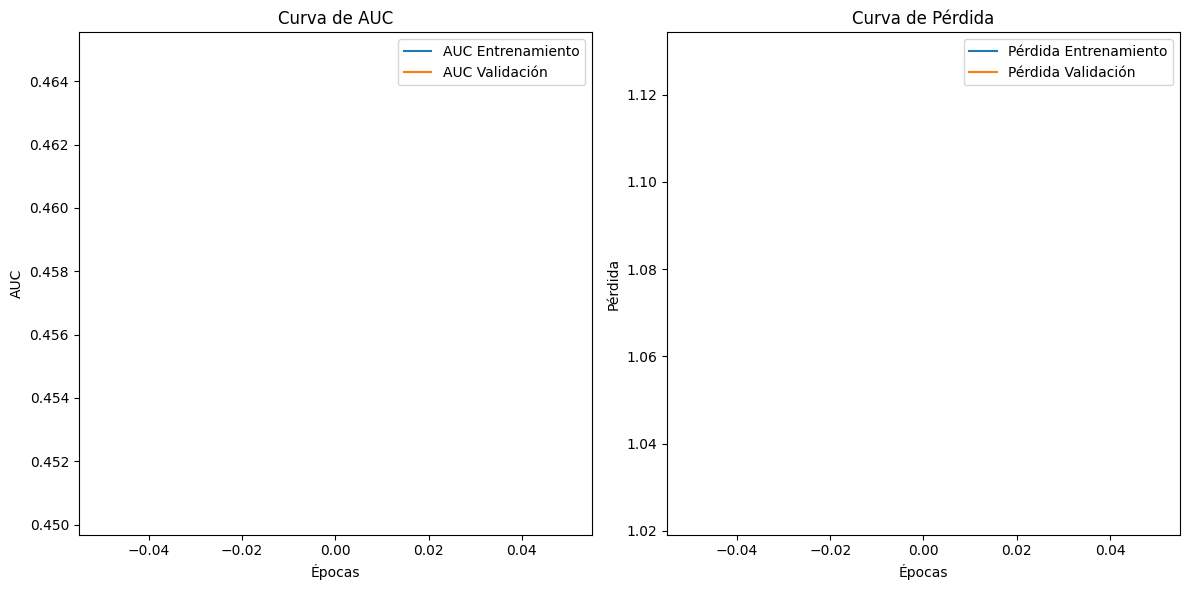

Optimizador: SGD
AUC Promedio: 0.8608
AUC Entrenamiento Promedio: 0.7681
AUC Validación Promedio: 0.8235
Pérdida Promedio: 0.1871
Pérdida Validación Promedio: 0.1642
Optimizador: Adam
AUC Promedio: 0.9351
AUC Entrenamiento Promedio: 0.8856
AUC Validación Promedio: 0.9178
Pérdida Promedio: 0.1051
Pérdida Validación Promedio: 0.0855
Optimizador: RMSprop
AUC Promedio: 0.9667
AUC Entrenamiento Promedio: 0.8353
AUC Validación Promedio: 0.9308
Pérdida Promedio: 0.1269
Pérdida Validación Promedio: 0.0939
Optimizador: Adagrad
AUC Promedio: 0.6512
AUC Entrenamiento Promedio: 0.5751
AUC Validación Promedio: 0.6408
Pérdida Promedio: 0.7274
Pérdida Validación Promedio: 0.5765
Optimizador: Adadelta
AUC Promedio: 0.4342
AUC Entrenamiento Promedio: 0.4670
AUC Validación Promedio: 0.4272
Pérdida Promedio: 1.0246
Pérdida Validación Promedio: 1.1299


In [33]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import AUC
import numpy as np
import tensorflow as tf

# Fijar semilla para reproducibilidad
np.random.seed(42)  # Para la aleatorización de datos
tf.random.set_seed(42)  # Para la inicialización de pesos

# Función para construir el modelo
def construir_modelo(arquitectura, optimizador, input_dim):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))  # Capa de entrada con 63 características (input_dim)

    # Añadir capas ocultas según la arquitectura especificada
    for units, dropout_rate in arquitectura:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))

    # Capa de salida con 1 neurona para clasificación binaria
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compilación con el optimizador pasado como argumento
    model.compile(optimizer=optimizador,
                  loss='binary_crossentropy',
                  metrics=[AUC(name='auc')])
    
    return model

# Función para entrenar y evaluar el modelo
def entrenar_y_evaluar(model, X_train_scaled, y_train):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    train_auc_scores = []
    val_auc_scores = []
    losses = []
    val_losses = []

    for train_index, val_index in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)

        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=500,
                            callbacks=[early_stop],
                            verbose=0)

        # Asegúrate de que el historial esté bien estructurado
        if 'auc' in history.history:
            train_auc_scores.append(history.history['auc'])
        if 'val_auc' in history.history:
            val_auc_scores.append(history.history['val_auc'])
        losses.append(history.history['loss'])
        val_losses.append(history.history['val_loss'])
        
        val_pred = model.predict(X_val_fold).ravel()
        auc = roc_auc_score(y_val_fold, val_pred)
        auc_scores.append(auc)
    
    mean_auc = np.mean(auc_scores)
    
    # Promediar AUC y pérdidas por fold
    mean_train_auc = np.mean([np.mean(train) for train in train_auc_scores], axis=0)
    mean_val_auc = np.mean([np.mean(val) for val in val_auc_scores], axis=0)
    mean_loss = np.mean([np.mean(loss) for loss in losses], axis=0)
    mean_val_loss = np.mean([np.mean(val_loss) for val_loss in val_losses], axis=0)

    return mean_auc, mean_train_auc, mean_val_auc, mean_loss, mean_val_loss, train_auc_scores, val_auc_scores, losses, val_losses


# Función para graficar las curvas de pérdida y AUC
def graficar_curvas(train_auc_scores, val_auc_scores, losses, val_losses):
    plt.figure(figsize=(12, 6))

    # Graficar AUC
    plt.subplot(1, 2, 1)
    train_auc_mean = np.mean(np.concatenate(train_auc_scores), axis=0)
    val_auc_mean = np.mean(np.concatenate(val_auc_scores), axis=0)
    plt.plot(train_auc_mean, label='AUC Entrenamiento')
    plt.plot(val_auc_mean, label='AUC Validación')
    plt.title('Curva de AUC')
    plt.xlabel('Épocas')
    plt.ylabel('AUC')
    plt.legend()

    # Graficar pérdidas
    plt.subplot(1, 2, 2)
    loss_mean = np.mean(np.concatenate(losses), axis=0)
    val_loss_mean = np.mean(np.concatenate(val_losses), axis=0)
    plt.plot(loss_mean, label='Pérdida Entrenamiento')
    plt.plot(val_loss_mean, label='Pérdida Validación')
    plt.title('Curva de Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Definir la función para probar optimizadores
def probar_optimizadores(arquitectura, optimizadores, X_train_scaled, y_train):
    resultados = {}
    for opt in optimizadores:
        model = construir_modelo(arquitectura, opt, X_train_scaled.shape[1])  # Construir el modelo con la arquitectura y optimizador
        mean_auc, mean_train_auc, mean_val_auc, mean_loss, mean_val_loss, train_auc_scores, val_auc_scores, losses, val_losses = entrenar_y_evaluar(model, X_train_scaled, y_train)  # Entrenar y evaluar el modelo
        resultados[opt] = {
            'AUC Promedio': mean_auc,
            'AUC Entrenamiento Promedio': mean_train_auc,
            'AUC Validación Promedio': mean_val_auc,
            'Pérdida Promedio': mean_loss,
            'Pérdida Validación Promedio': mean_val_loss
        }
        graficar_curvas(train_auc_scores, val_auc_scores, losses, val_losses)  # Graficar curvas

    return resultados

# Lista de optimizadores a probar
optimizadores = [SGD(), Adam(), RMSprop(), Adagrad(), Adadelta()]

# Probar optimizadores en las arquitecturas 1 a 4 capas
arquitecturas = [
    [(64, 0.3)],  # Arquitectura de 1 capa oculta
    [(128, 0.3), (64, 0.3)],  # Arquitectura de 2 capas ocultas
    [(128, 0.3), (64, 0.3), (32, 0.2)],  # Arquitectura de 3 capas ocultas
    [(128, 0.3), (64, 0.3), (32, 0.2), (16, 0.2)]  # Arquitectura de 4 capas ocultas
]

# Asumiendo que X_train_scaled e y_train están definidos
for i, arquitectura in enumerate(arquitecturas, start=1):
    print(f"\nProbando optimizadores para arquitectura {i}: {arquitectura}")
    resultados = probar_optimizadores(arquitectura, optimizadores, X_train_scaled, y_train)
    for opt, resultado in resultados.items():
        print(f"Optimizador: {opt.__class__.__name__}")
        print(f"AUC Promedio: {resultado['AUC Promedio']:.4f}")
        print(f"AUC Entrenamiento Promedio: {resultado['AUC Entrenamiento Promedio']:.4f}")
        print(f"AUC Validación Promedio: {resultado['AUC Validación Promedio']:.4f}")
        print(f"Pérdida Promedio: {resultado['Pérdida Promedio']:.4f}")
        print(f"Pérdida Validación Promedio: {resultado['Pérdida Validación Promedio']:.4f}")



Probando optimizadores para arquitectura 1: [(64, 0.3)]
52/52 [==============================] - 0s 736us/step


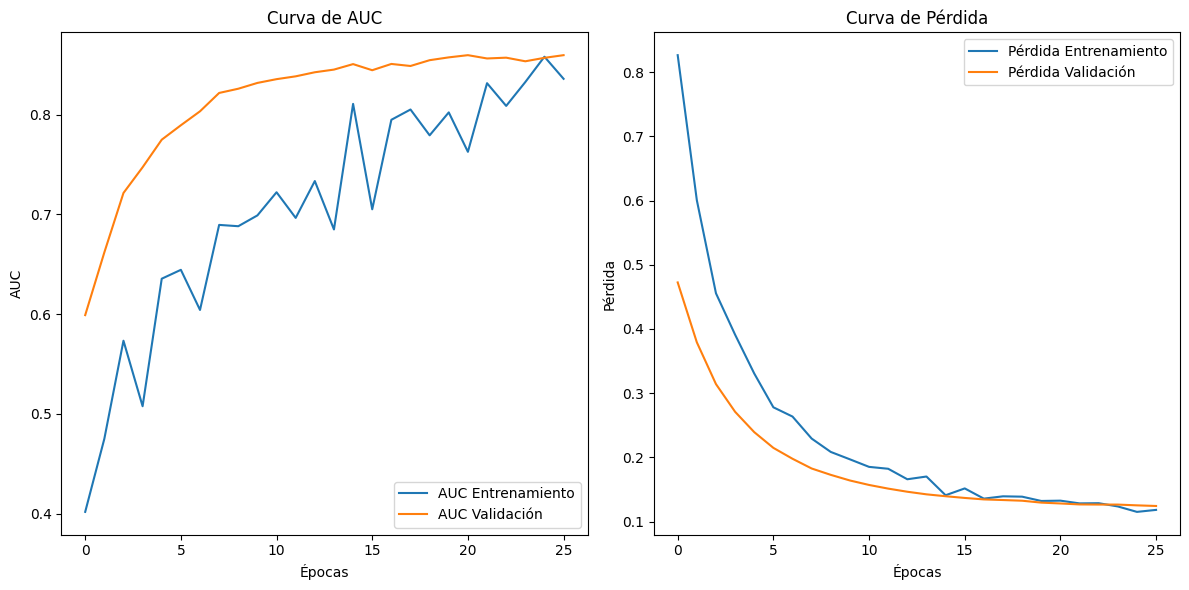

52/52 [==============================] - 0s 755us/step


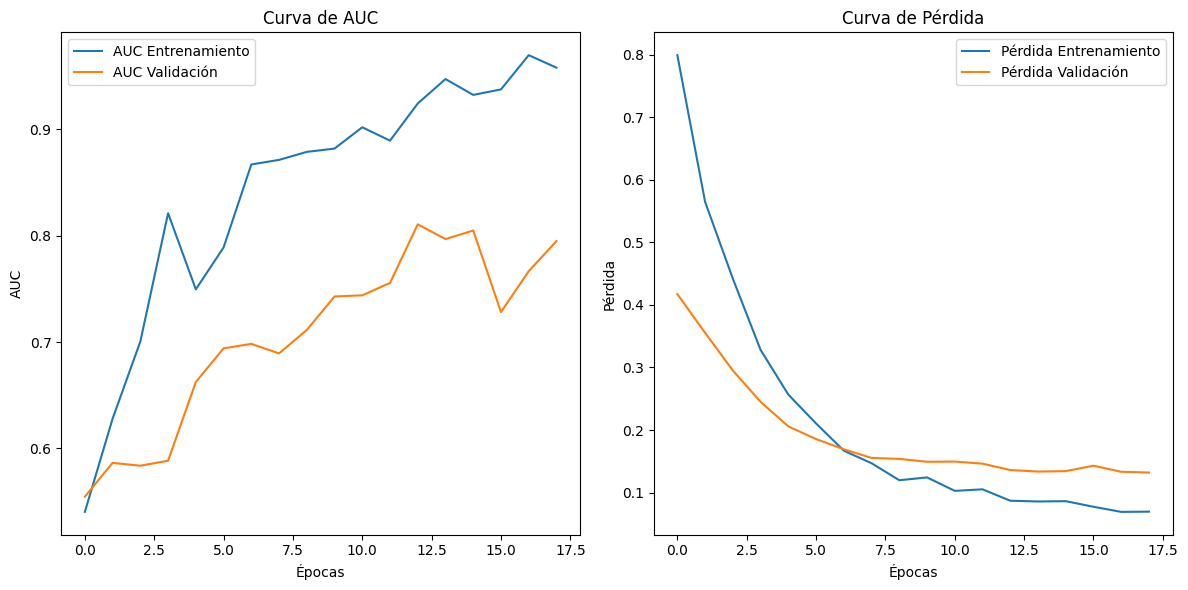

52/52 [==============================] - 0s 765us/step


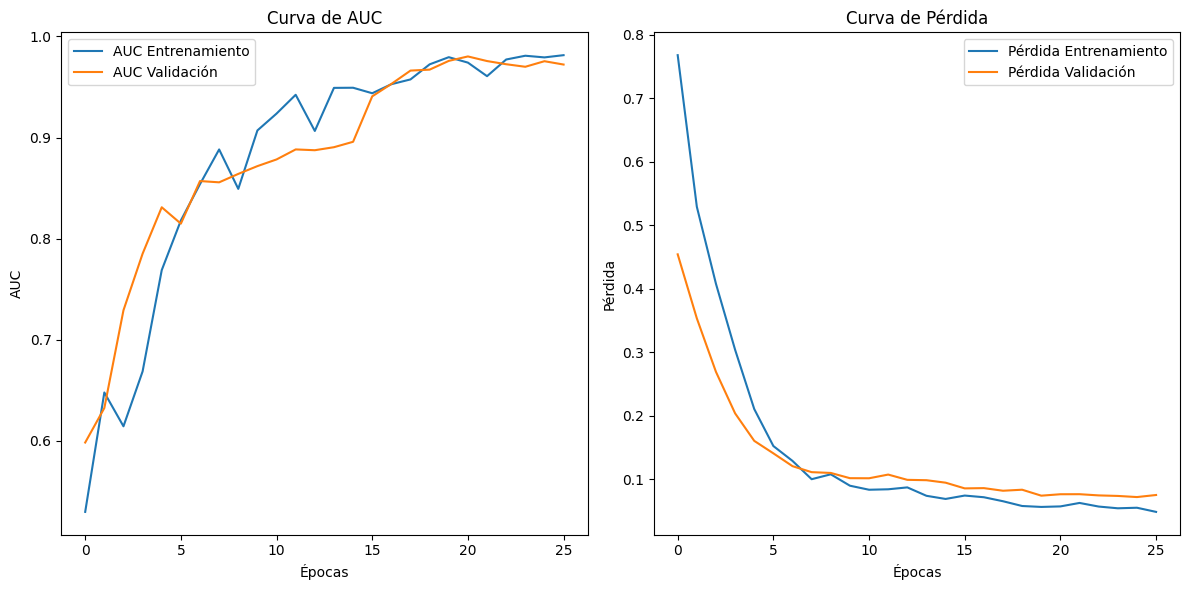

52/52 [==============================] - 0s 745us/step


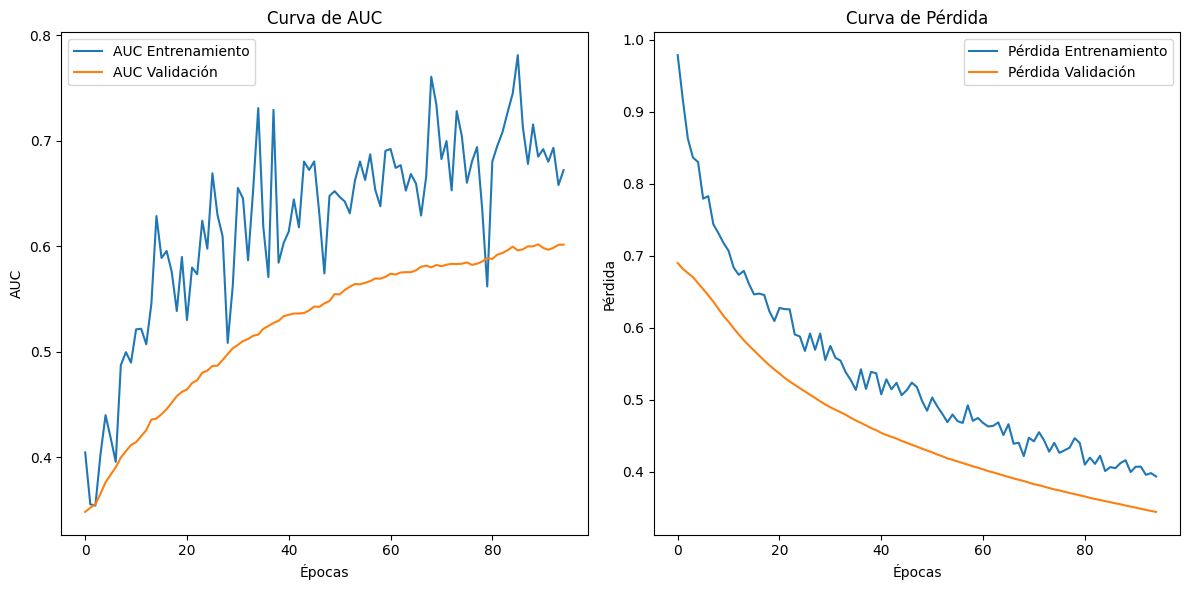

52/52 [==============================] - 0s 863us/step


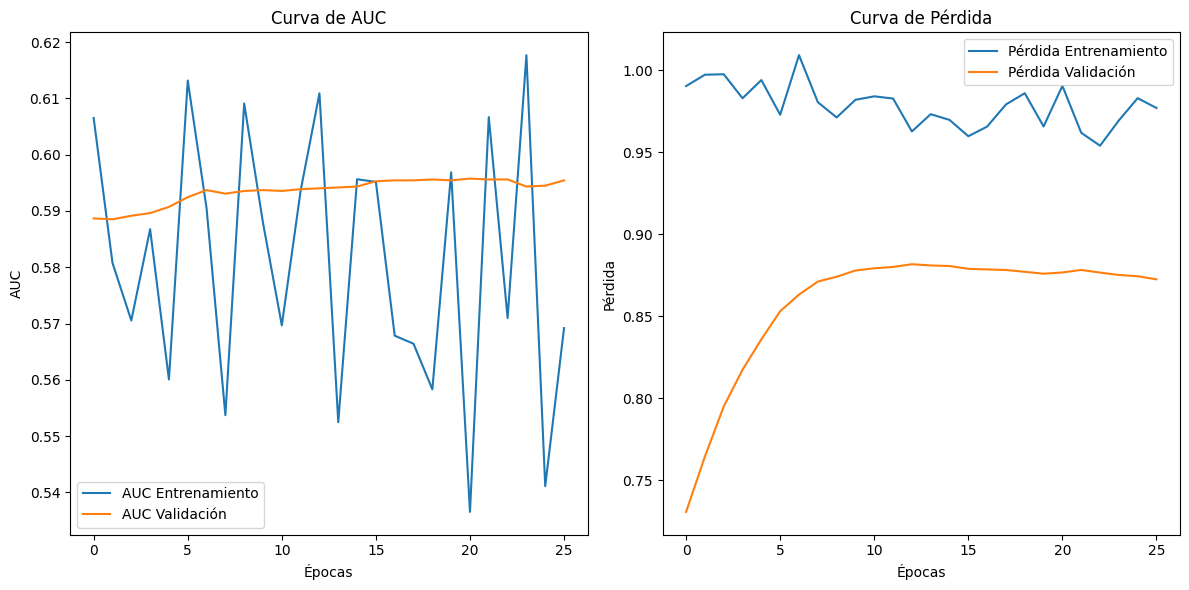

Optimizador: SGD
AUC Promedio: 0.9179
Pérdida Promedio: 0.2334
Pérdida Validación Promedio: 0.1834
Optimizador: Adam
AUC Promedio: 0.9524
Pérdida Promedio: 0.2135
Pérdida Validación Promedio: 0.1911
Optimizador: RMSprop
AUC Promedio: 0.9936
Pérdida Promedio: 0.1483
Pérdida Validación Promedio: 0.1302
Optimizador: Adagrad
AUC Promedio: 0.8100
Pérdida Promedio: 0.5372
Pérdida Validación Promedio: 0.4606
Optimizador: Adadelta
AUC Promedio: 0.5949
Pérdida Promedio: 0.9786
Pérdida Validación Promedio: 0.8588

Probando optimizadores para arquitectura 2: [(128, 0.3), (64, 0.3)]
52/52 [==============================] - 0s 1ms/step


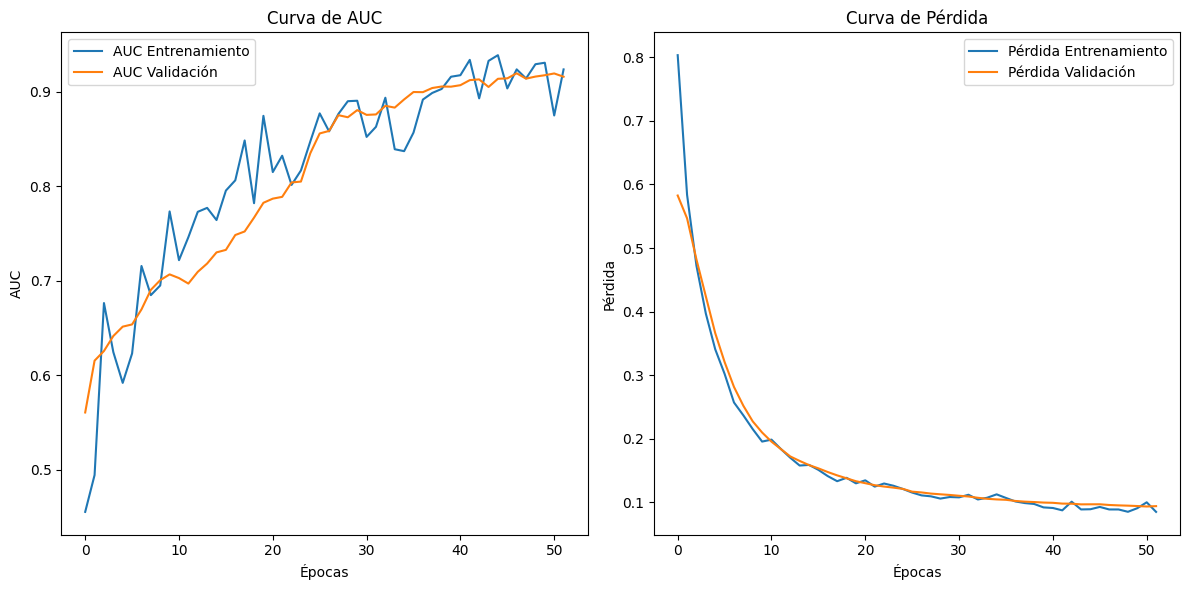

52/52 [==============================] - 0s 922us/step


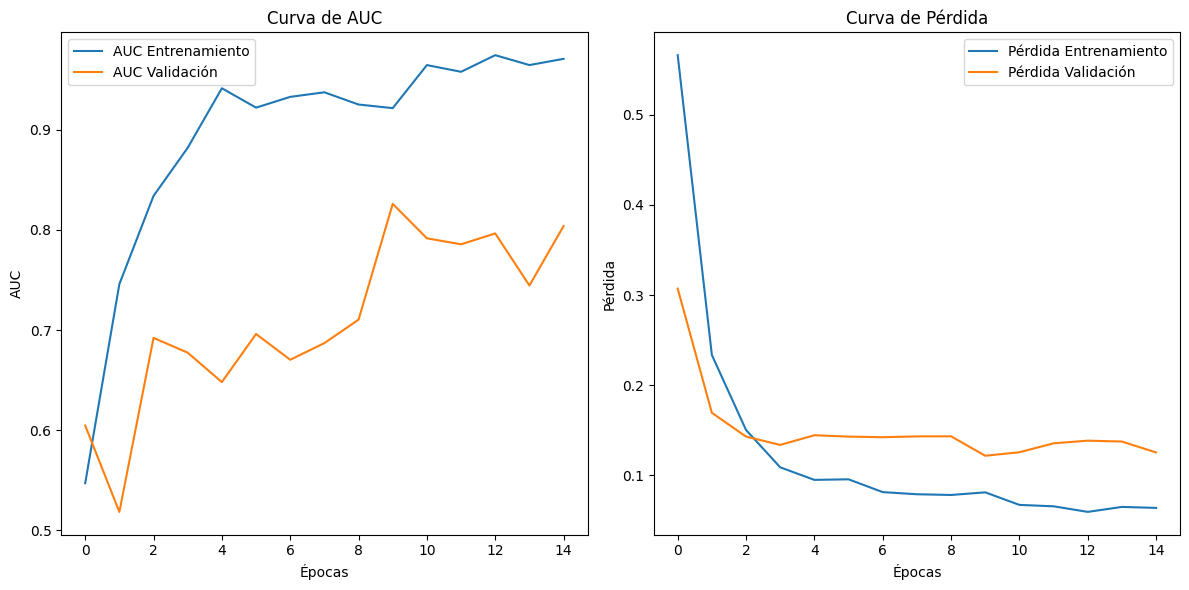

52/52 [==============================] - 0s 902us/step


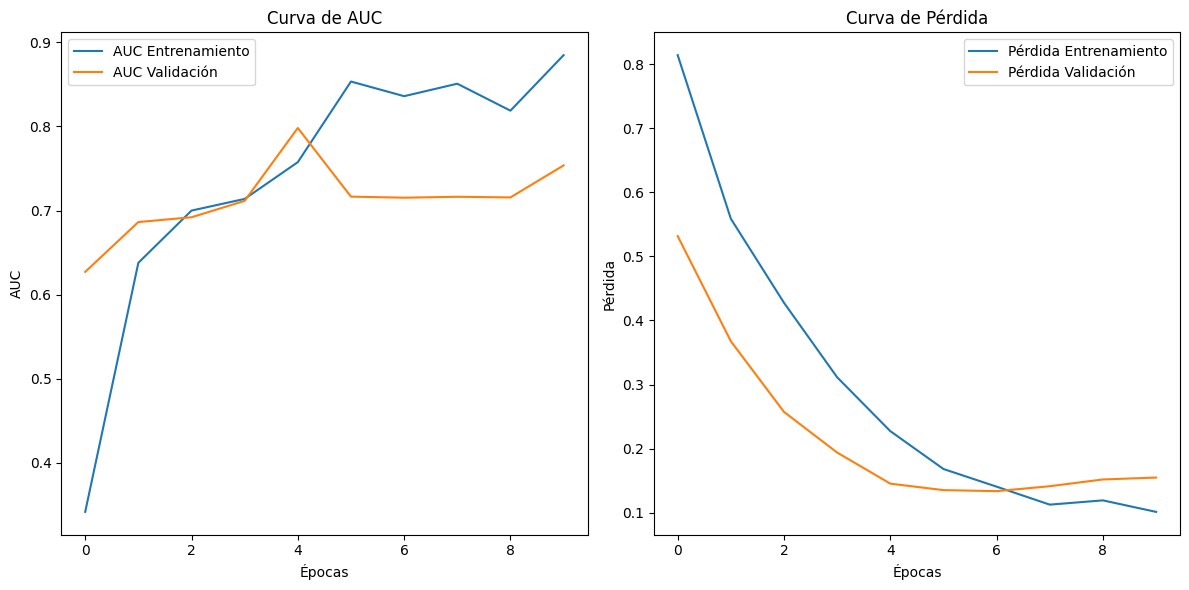

52/52 [==============================] - 0s 922us/step


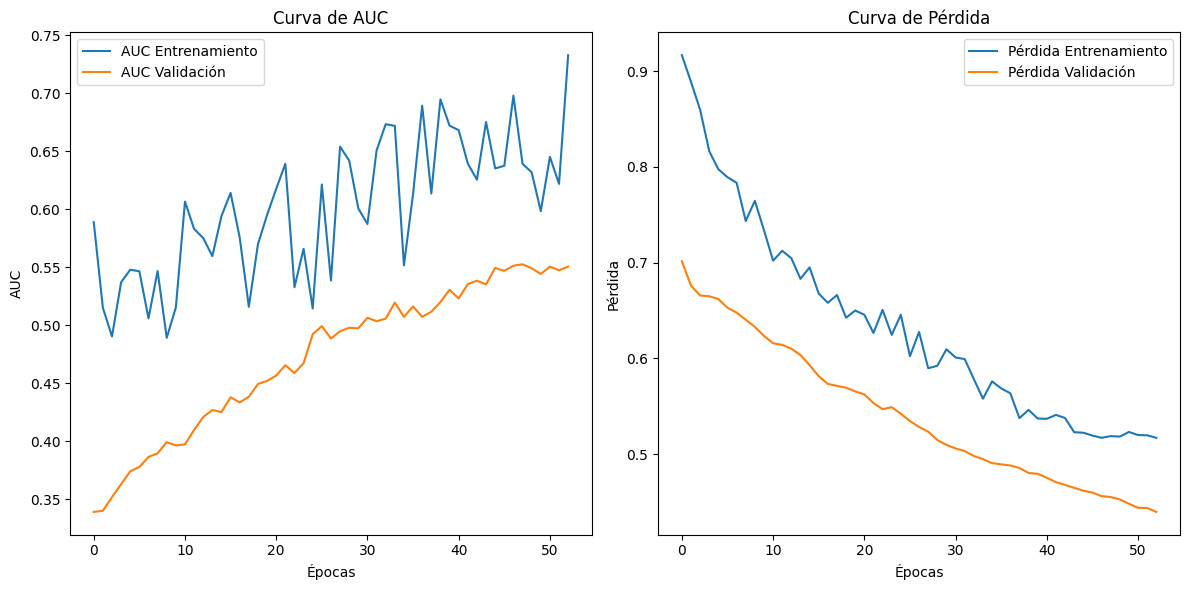

52/52 [==============================] - 0s 1ms/step


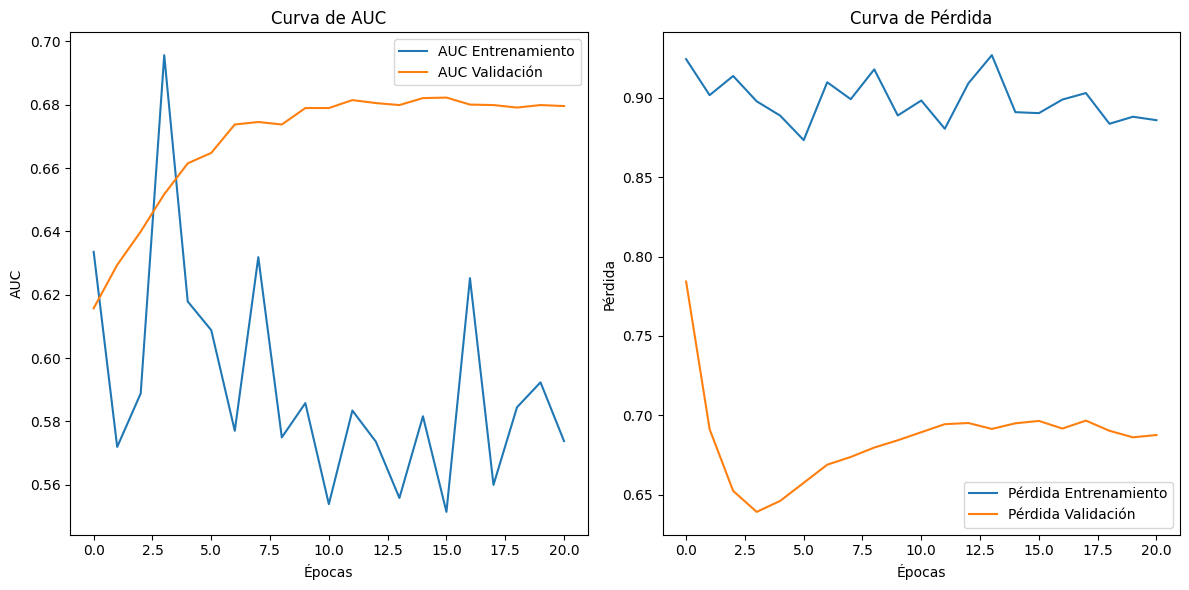

Optimizador: SGD
AUC Promedio: 0.9734
Pérdida Promedio: 0.1669
Pérdida Validación Promedio: 0.1668
Optimizador: Adam
AUC Promedio: 0.9636
Pérdida Promedio: 0.1262
Pérdida Validación Promedio: 0.1504
Optimizador: RMSprop
AUC Promedio: 0.9212
Pérdida Promedio: 0.2980
Pérdida Validación Promedio: 0.2212
Optimizador: Adagrad
AUC Promedio: 0.7853
Pérdida Promedio: 0.6333
Pérdida Validación Promedio: 0.5411
Optimizador: Adadelta
AUC Promedio: 0.6484
Pérdida Promedio: 0.8987
Pérdida Validación Promedio: 0.6852

Probando optimizadores para arquitectura 3: [(128, 0.3), (64, 0.3), (32, 0.2)]
52/52 [==============================] - 0s 1ms/step


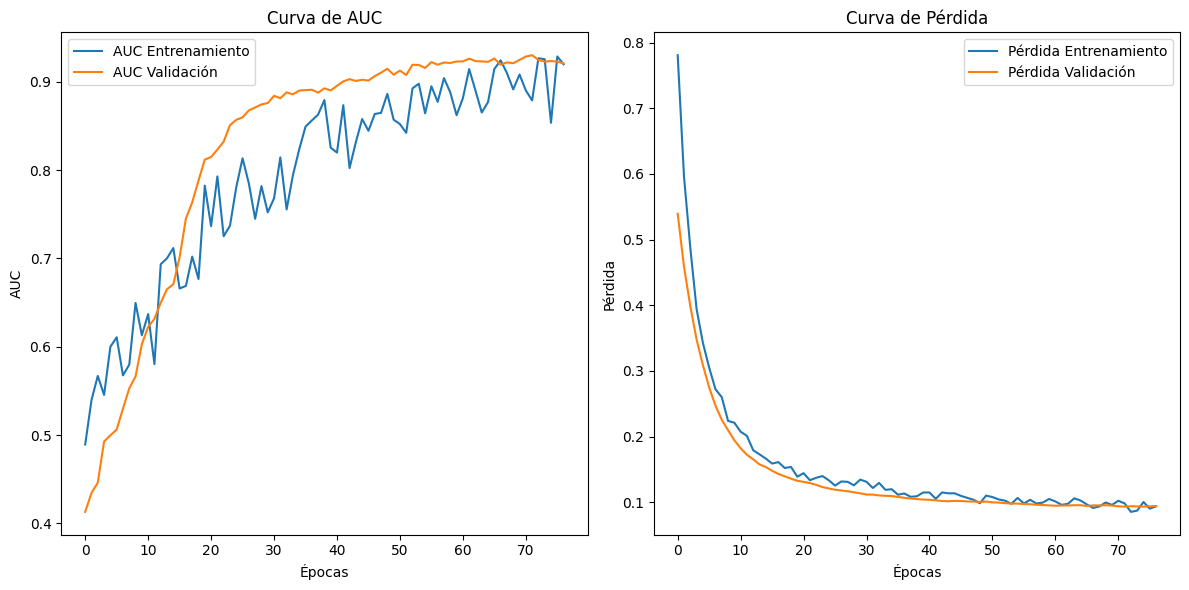

52/52 [==============================] - 0s 1ms/step


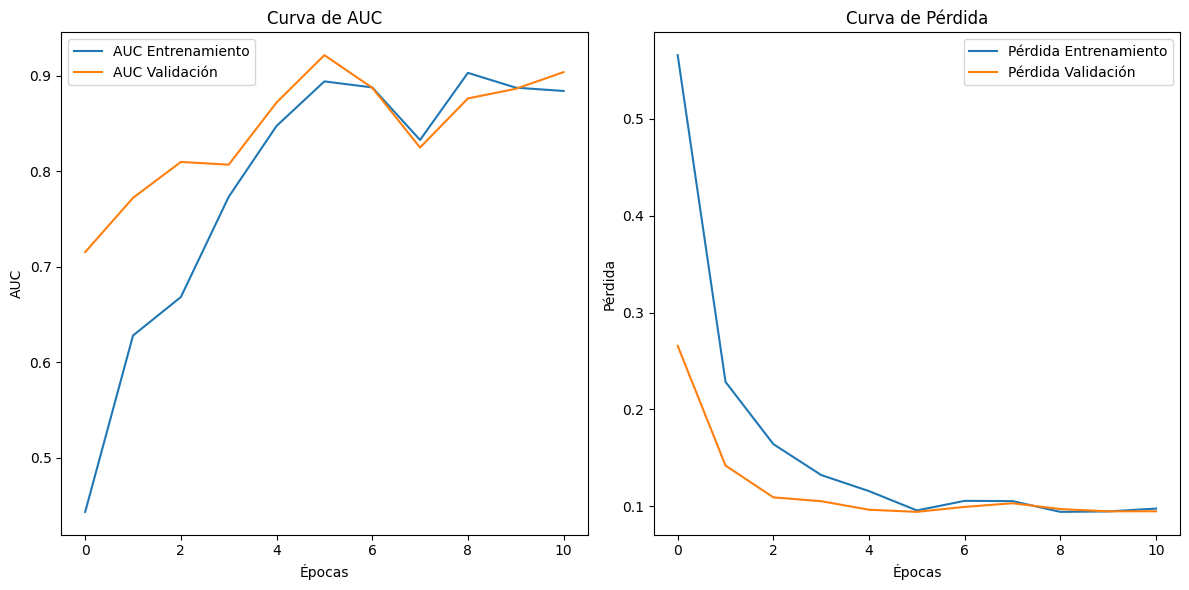

52/52 [==============================] - 0s 1ms/step


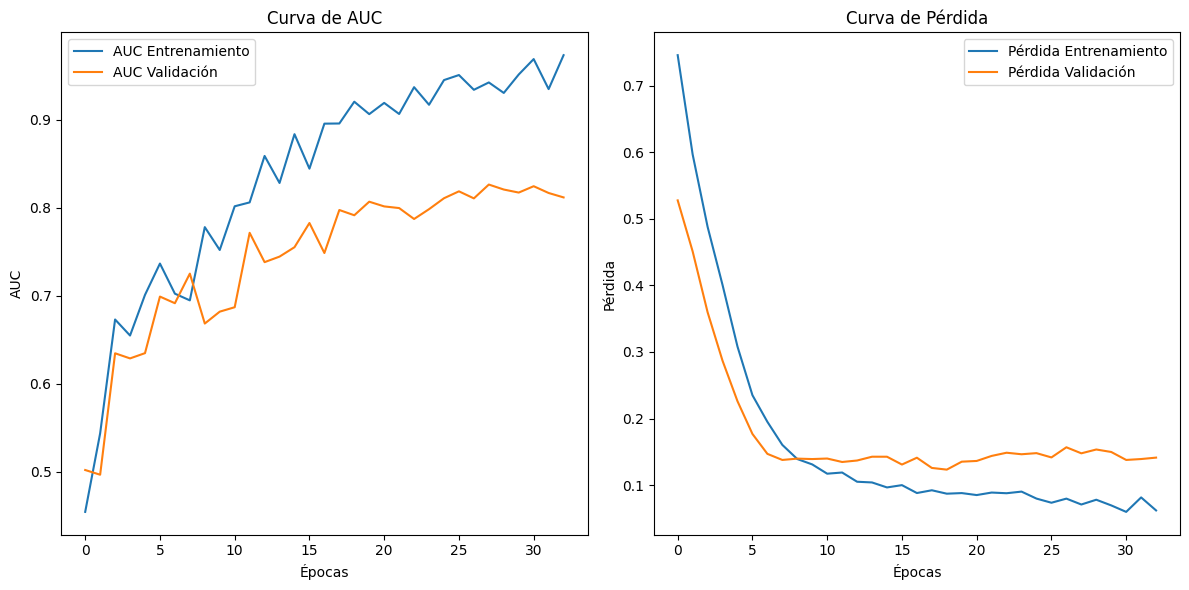

52/52 [==============================] - 0s 1ms/step


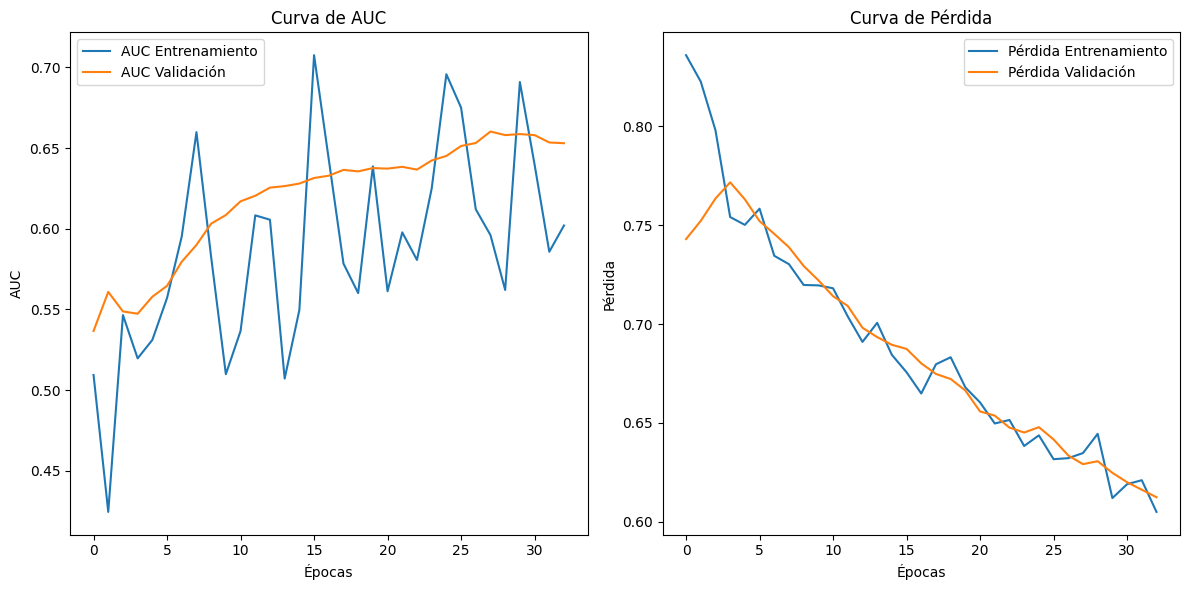

52/52 [==============================] - 0s 1ms/step


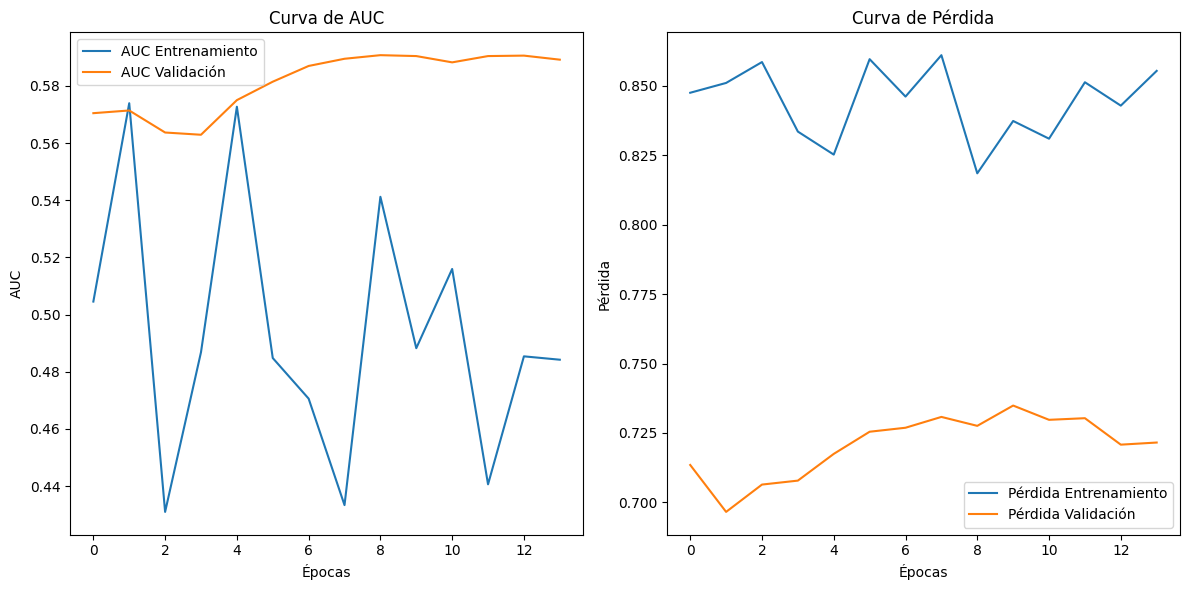

Optimizador: SGD
AUC Promedio: 0.9753
Pérdida Promedio: 0.1537
Pérdida Validación Promedio: 0.1380
Optimizador: Adam
AUC Promedio: 0.9656
Pérdida Promedio: 0.1635
Pérdida Validación Promedio: 0.1183
Optimizador: RMSprop
AUC Promedio: 0.9490
Pérdida Promedio: 0.1638
Pérdida Validación Promedio: 0.1769
Optimizador: Adagrad
AUC Promedio: 0.6552
Pérdida Promedio: 0.6889
Pérdida Validación Promedio: 0.6856
Optimizador: Adadelta
AUC Promedio: 0.4967
Pérdida Promedio: 0.8442
Pérdida Validación Promedio: 0.7207

Probando optimizadores para arquitectura 4: [(128, 0.3), (64, 0.3), (32, 0.2), (16, 0.2)]
52/52 [==============================] - 0s 1ms/step


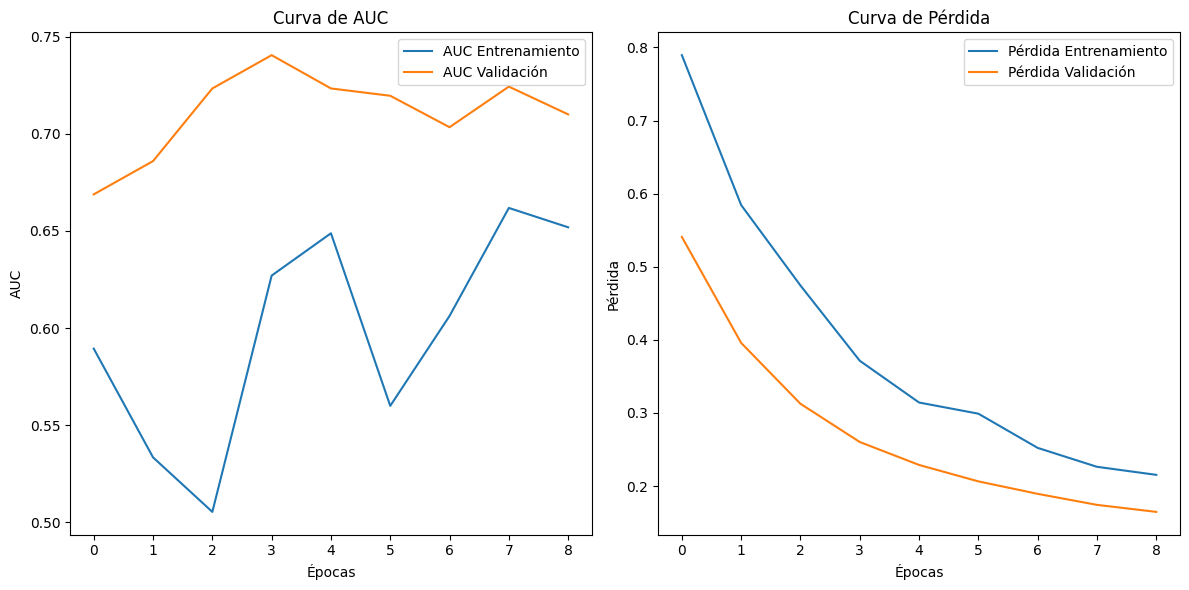

52/52 [==============================] - 0s 1ms/step


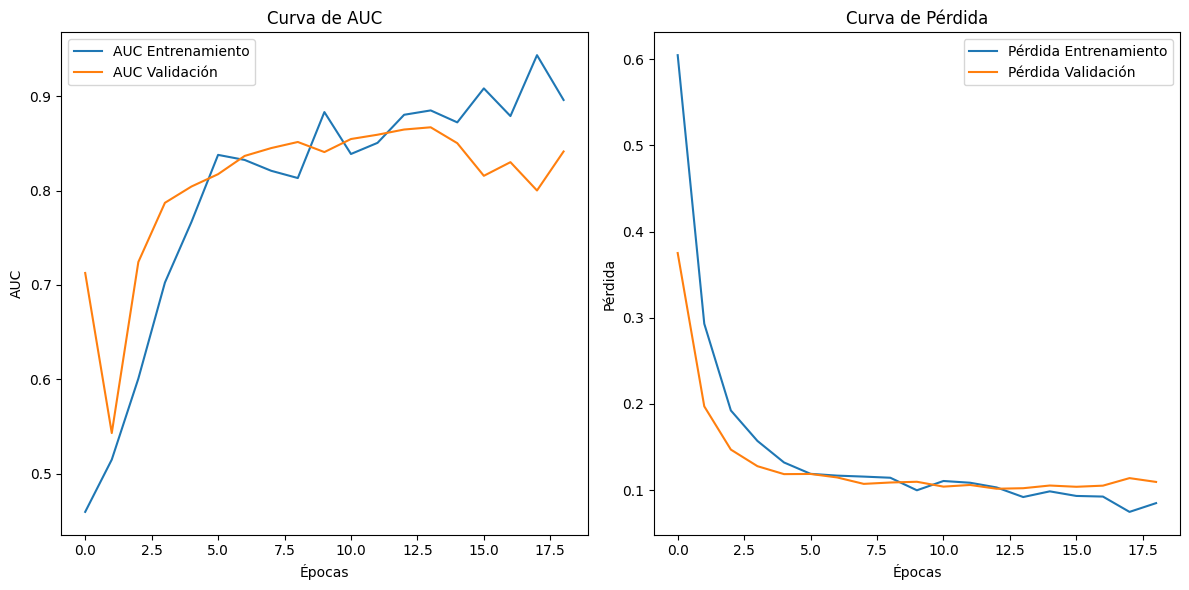

52/52 [==============================] - 0s 1ms/step


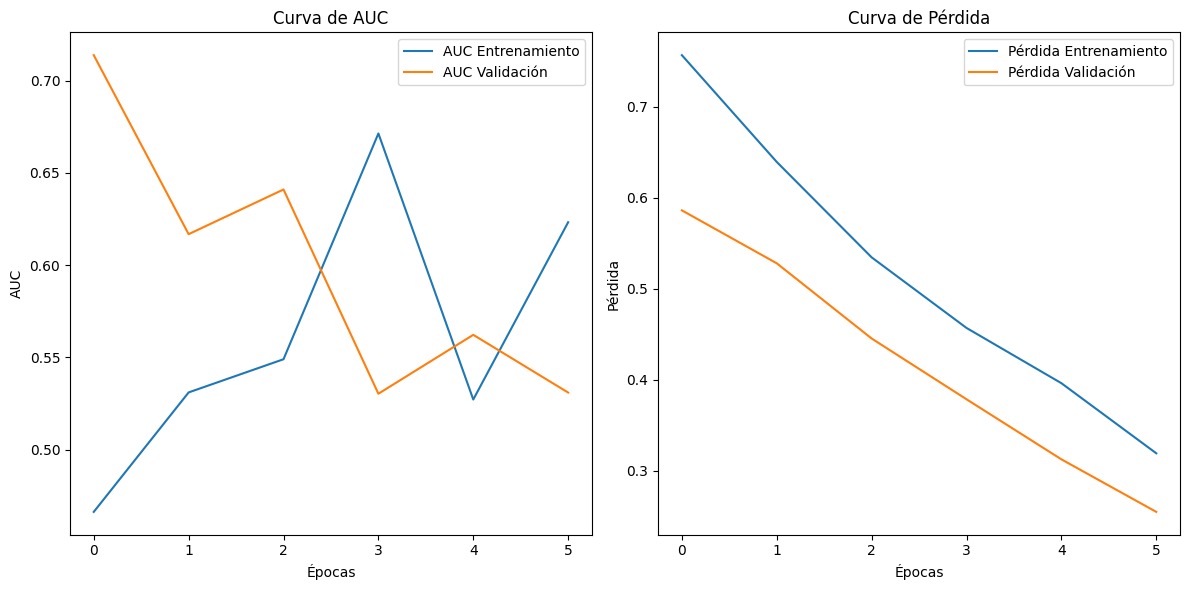

52/52 [==============================] - 0s 1ms/step


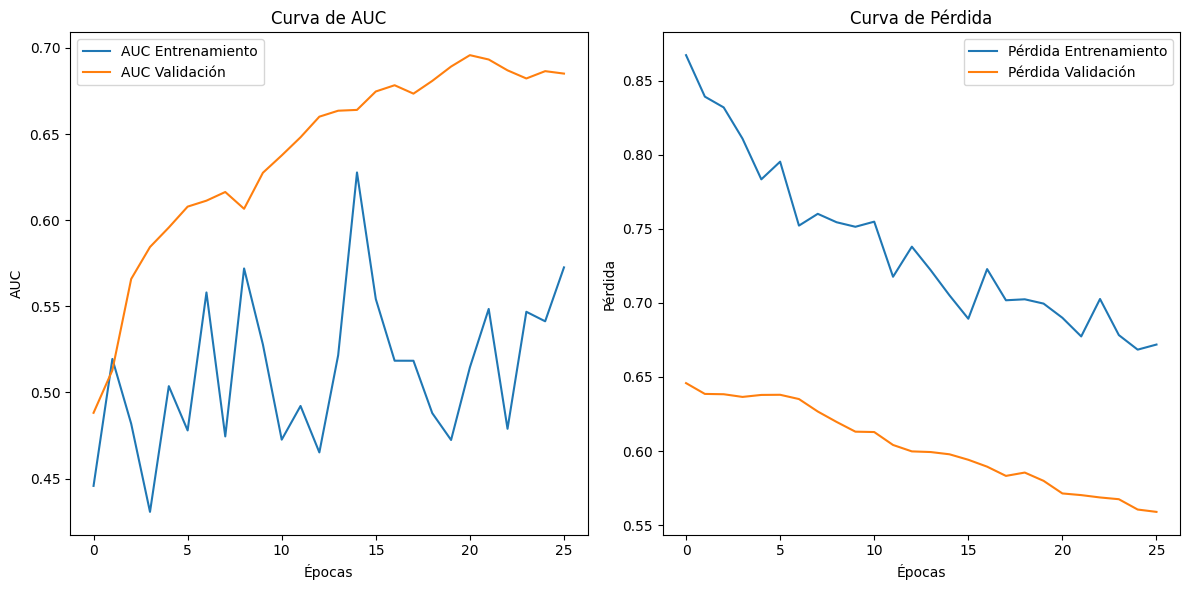

52/52 [==============================] - 0s 1ms/step


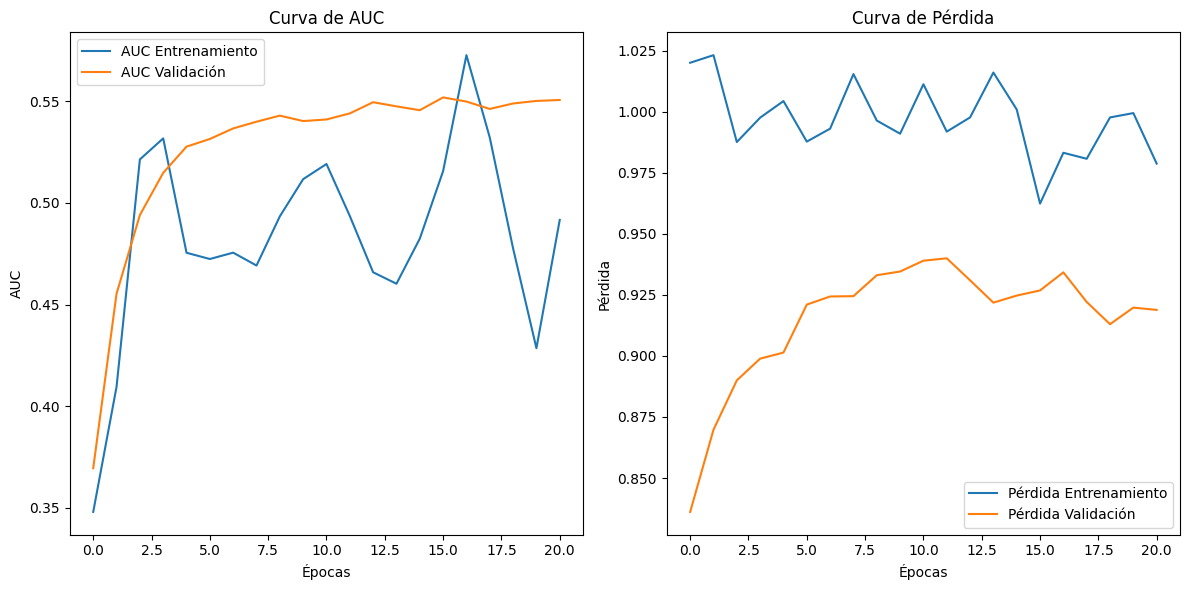

Optimizador: SGD
AUC Promedio: 0.7078
Pérdida Promedio: 0.3919
Pérdida Validación Promedio: 0.2748
Optimizador: Adam
AUC Promedio: 0.9542
Pérdida Promedio: 0.1475
Pérdida Validación Promedio: 0.1303
Optimizador: RMSprop
AUC Promedio: 0.6237
Pérdida Promedio: 0.5171
Pérdida Validación Promedio: 0.4174
Optimizador: Adagrad
AUC Promedio: 0.5912
Pérdida Promedio: 0.7380
Pérdida Validación Promedio: 0.6028
Optimizador: Adadelta
AUC Promedio: 0.5042
Pérdida Promedio: 0.9970
Pérdida Validación Promedio: 0.9155


In [34]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import AUC
import numpy as np
import tensorflow as tf

# Fijar semilla para reproducibilidad
np.random.seed(42)  # Para la aleatorización de datos
tf.random.set_seed(42)  # Para la inicialización de pesos

# Función para construir el modelo
def construir_modelo(arquitectura, optimizador, input_dim):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))  # Capa de entrada con 63 características (input_dim)

    # Añadir capas ocultas según la arquitectura especificada
    for units, dropout_rate in arquitectura:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))

    # Capa de salida con 1 neurona para clasificación binaria
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compilación con el optimizador pasado como argumento
    model.compile(optimizer=optimizador,
                  loss='binary_crossentropy',
                  metrics=[AUC(name='auc')])
    
    return model

# Función para entrenar y evaluar el modelo
def entrenar_y_evaluar(model, X_train_scaled, y_train):
    # No usar KFold, entrenar con todo el conjunto
    early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
    
    history = model.fit(X_train_scaled, y_train,
                        validation_split=0.2,  # Usar una división de validación
                        epochs=500,
                        callbacks=[early_stop],
                        verbose=0)
    
    # Obtener AUC y pérdidas del entrenamiento
    train_auc_scores = history.history['auc']
    val_auc_scores = history.history['val_auc']
    losses = history.history['loss']
    val_losses = history.history['val_loss']
    
    # Obtener AUC en el conjunto de validación
    val_pred = model.predict(X_train_scaled).ravel()
    auc = roc_auc_score(y_train, val_pred)
    
    return auc, train_auc_scores, val_auc_scores, losses, val_losses

# Función para graficar las curvas de pérdida y AUC
def graficar_curvas(train_auc_scores, val_auc_scores, losses, val_losses):
    plt.figure(figsize=(12, 6))

    # Graficar AUC
    plt.subplot(1, 2, 1)
    plt.plot(train_auc_scores, label='AUC Entrenamiento')
    plt.plot(val_auc_scores, label='AUC Validación')
    plt.title('Curva de AUC')
    plt.xlabel('Épocas')
    plt.ylabel('AUC')
    plt.legend()

    # Graficar pérdidas
    plt.subplot(1, 2, 2)
    plt.plot(losses, label='Pérdida Entrenamiento')
    plt.plot(val_losses, label='Pérdida Validación')
    plt.title('Curva de Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Definir la función para probar optimizadores
def probar_optimizadores(arquitectura, optimizadores, X_train_scaled, y_train):
    resultados = {}
    for opt in optimizadores:
        model = construir_modelo(arquitectura, opt, X_train_scaled.shape[1])  # Construir el modelo con la arquitectura y optimizador
        auc, train_auc_scores, val_auc_scores, losses, val_losses = entrenar_y_evaluar(model, X_train_scaled, y_train)  # Entrenar y evaluar el modelo
        resultados[opt] = {
            'AUC Promedio': auc,
            'Pérdida Promedio': np.mean(losses),
            'Pérdida Validación Promedio': np.mean(val_losses)
        }
        graficar_curvas(train_auc_scores, val_auc_scores, losses, val_losses)  # Graficar curvas

    return resultados

# Lista de optimizadores a probar
optimizadores = [SGD(), Adam(), RMSprop(), Adagrad(), Adadelta()]

# Probar optimizadores en las arquitecturas 1 a 4 capas
arquitecturas = [
    [(64, 0.3)],  # Arquitectura de 1 capa oculta
    [(128, 0.3), (64, 0.3)],  # Arquitectura de 2 capas ocultas
    [(128, 0.3), (64, 0.3), (32, 0.2)],  # Arquitectura de 3 capas ocultas
    [(128, 0.3), (64, 0.3), (32, 0.2), (16, 0.2)]  # Arquitectura de 4 capas ocultas
]

# Asumiendo que X_train_scaled e y_train están definidos
for i, arquitectura in enumerate(arquitecturas, start=1):
    print(f"\nProbando optimizadores para arquitectura {i}: {arquitectura}")
    resultados = probar_optimizadores(arquitectura, optimizadores, X_train_scaled, y_train)
    for opt, resultado in resultados.items():
        print(f"Optimizador: {opt.__class__.__name__}")
        print(f"AUC Promedio: {resultado['AUC Promedio']:.4f}")
        print(f"Pérdida Promedio: {resultado['Pérdida Promedio']:.4f}")
        print(f"Pérdida Validación Promedio: {resultado['Pérdida Validación Promedio']:.4f}")


Seleccionada arquitectura de 3 capas ocultas con optimizadores de SGD, ADAM y RMSprop

In [35]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def construir_modelo(arquitectura, optimizador, input_dim):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    for units, dropout_rate in arquitectura:
        model.add(layers.Dense(units, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizador,
                  loss='binary_crossentropy',
                  metrics=[AUC(name='auc')])
    return model

def entrenar_y_evaluar(model, X, y, batch_size):
    early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)
    history = model.fit(X, y,
                        validation_split=0.2,
                        batch_size=batch_size,
                        epochs=500,
                        callbacks=[early_stop],
                        verbose=0)
    y_pred = model.predict(X).ravel()
    auc = roc_auc_score(y, y_pred)
    return auc, history

# Grilla de hiperparámetros
learning_rates = [1e-2, 1e-3, 1e-4]
batch_sizes = [16, 32, 64]
optimizadores = {
    'Adam': Adam,
    'SGD': SGD,
    'RMSprop': RMSprop
}

# Resultados
resultados = []

for opt_name, opt_class in optimizadores.items():
    for lr in learning_rates:
        for batch in batch_sizes:
            print(f"\nProbando {opt_name} con lr={lr}, batch_size={batch}")
            opt = opt_class(learning_rate=lr)
            model = construir_modelo(arquitectura, opt, X_train_scaled.shape[1])
            auc, history = entrenar_y_evaluar(model, X_train_scaled, y_train, batch)
            resultados.append({
                'Optimizador': opt_name,
                'Learning Rate': lr,
                'Batch Size': batch,
                'AUC': auc
            })

# Mostrar mejores resultados
sorted_res = sorted(resultados, key=lambda x: x['AUC'], reverse=True)
print("\nMejores configuraciones (ordenadas por AUC):")
for res in sorted_res[:5]:
    print(res)



Probando Adam con lr=0.01, batch_size=16
52/52 [==============================] - 0s 1ms/step

Probando Adam con lr=0.01, batch_size=32
52/52 [==============================] - 0s 1ms/step

Probando Adam con lr=0.01, batch_size=64
52/52 [==============================] - 0s 1ms/step

Probando Adam con lr=0.001, batch_size=16
52/52 [==============================] - 0s 1ms/step

Probando Adam con lr=0.001, batch_size=32
52/52 [==============================] - 0s 1ms/step

Probando Adam con lr=0.001, batch_size=64
52/52 [==============================] - 0s 1ms/step

Probando Adam con lr=0.0001, batch_size=16
52/52 [==============================] - 0s 1ms/step

Probando Adam con lr=0.0001, batch_size=32
52/52 [==============================] - 0s 1ms/step

Probando Adam con lr=0.0001, batch_size=64
52/52 [==============================] - 0s 1ms/step

Probando SGD con lr=0.01, batch_size=16
52/52 [==============================] - 0s 1ms/step

Probando SGD con lr=0.01, batch_size=32
5

13/13 [==============================] - 0s 1ms/step


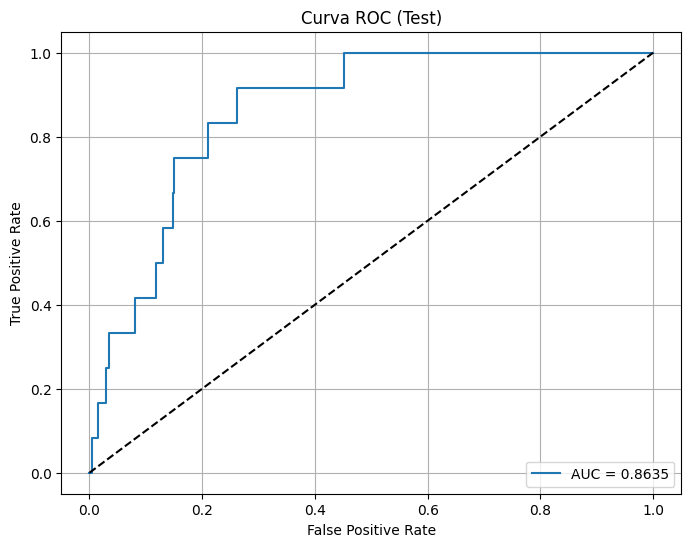

In [40]:
from sklearn.metrics import roc_curve, auc

# Predecir en test
y_test_pred = modelo_final.predict(X_val_scaled).ravel()

# Curva ROC sobre test
fpr, tpr, thresholds = roc_curve(y_val, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC (Test)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [42]:
# Realizar predicciones sobre el conjunto de prueba escalado
test_predictions = model.predict(X_test_scaled).flatten()

# Crear un DataFrame para la presentación (submission)
submission_df = pd.DataFrame({
    'ID': test_ids,  # Identificadores originales del conjunto de prueba
    'Bankruptcy': test_predictions  # Probabilidad predicha de quiebra
})

# Guardar el archivo de resultados
submission_df.to_csv("../results/submission_scaled_RN.csv", index=False)

# Mostrar las primeras filas para verificar
submission_df.head()

16/16 [==============================] - 0s 1ms/step


,ID,Bankruptcy
0,5,0.476780
1,14,0.377722
2,16,0.314704
3,26,0.876060
4,28,0.534419


In [4]:
# Fijar semillas para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Modelo mejorado
model = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')
])

# Compilación con tasa de aprendizaje explícita
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[AUC(name='auc')])


early_stop = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)

history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    epochs=100,  # subimos el máximo de epochs
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

# Evaluar en el set de validación
val_predictions = model.predict(X_val_scaled)
auc_score = roc_auc_score(y_val, val_predictions)

# Predecir para el archivo de test
test_predictions = model.predict(X_test_scaled)

Epoch 1/100
52/52 [==============================] - 2s 9ms/step - loss: 0.7758 - auc: 0.5639 - val_loss: 0.5422 - val_auc: 0.6839
Epoch 2/100
52/52 [==============================] - 0s 3ms/step - loss: 0.5662 - auc: 0.6299 - val_loss: 0.4034 - val_auc: 0.7335
Epoch 3/100
52/52 [==============================] - 0s 3ms/step - loss: 0.4596 - auc: 0.5492 - val_loss: 0.3132 - val_auc: 0.7293
Epoch 4/100
52/52 [==============================] - 0s 3ms/step - loss: 0.3488 - auc: 0.6985 - val_loss: 0.2417 - val_auc: 0.6889
Epoch 5/100
52/52 [==============================] - 0s 3ms/step - loss: 0.2799 - auc: 0.6494 - val_loss: 0.1934 - val_auc: 0.7327
Epoch 6/100
52/52 [==============================] - 0s 3ms/step - loss: 0.2235 - auc: 0.6799 - val_loss: 0.1582 - val_auc: 0.8258
Epoch 7/100
52/52 [==============================] - 0s 3ms/step - loss: 0.1800 - auc: 0.7550 - val_loss: 0.1366 - val_auc: 0.8524
Epoch 8/100
52/52 [==============================] - 0s 3ms/step - loss: 0.1615 - a

In [5]:
# Crear DataFrame de submission con las predicciones del modelo (basado en PCA)
submission_df = pd.DataFrame({
    'ID': test_ids,  # Usamos test_ids guardado al inicio
    'Bankruptcy': test_predictions.flatten()
})

# Guardar el archivo correctamente
submission_df.to_csv("../results/submission_scaled1.csv", index=False)

# Verificar
submission_df.head()

,ID,Bankruptcy
0,5,0.008460
1,14,0.007052
2,16,0.014421
3,26,0.001890
4,28,0.020560
